## CHPT Stock

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',100)

In [2]:
chpt = yf.download('CHPT')

[*********************100%***********************]  1 of 1 completed


In [3]:
chpt = chpt.Close.to_frame()

In [4]:
chpt['d_returns'] = np.log(chpt.div(chpt.shift(1)))

In [5]:
chpt

Close  d_returns
Date                        
2019-09-16   9.76        NaN
2019-09-17   9.76   0.000000
2019-09-18   9.72  -0.004107
2019-09-19   9.72   0.000000
2019-09-20   9.85   0.013286
...           ...        ...
2024-08-12   1.64  -0.030032
2024-08-13   1.78   0.081917
2024-08-14   1.74  -0.022728
2024-08-15   1.79   0.028330
2024-08-16   1.79   0.000000

[1239 rows x 2 columns]

In [6]:
chpt.dropna(inplace=True)

In [7]:
chpt.d_returns.sum()

-1.6960768253345038

In [8]:
np.exp(chpt.d_returns.sum())

0.1834016311348078

In [9]:
chpt['cumm_returns'] = chpt.d_returns.cumsum().apply(np.exp)
chpt

Close  d_returns  cumm_returns
Date                                      
2019-09-17   9.76   0.000000      1.000000
2019-09-18   9.72  -0.004107      0.995902
2019-09-19   9.72   0.000000      0.995902
2019-09-20   9.85   0.013286      1.009221
2019-09-23   9.85   0.000000      1.009221
...           ...        ...           ...
2024-08-12   1.64  -0.030032      0.168033
2024-08-13   1.78   0.081917      0.182377
2024-08-14   1.74  -0.022728      0.178279
2024-08-15   1.79   0.028330      0.183402
2024-08-16   1.79   0.000000      0.183402

[1238 rows x 3 columns]

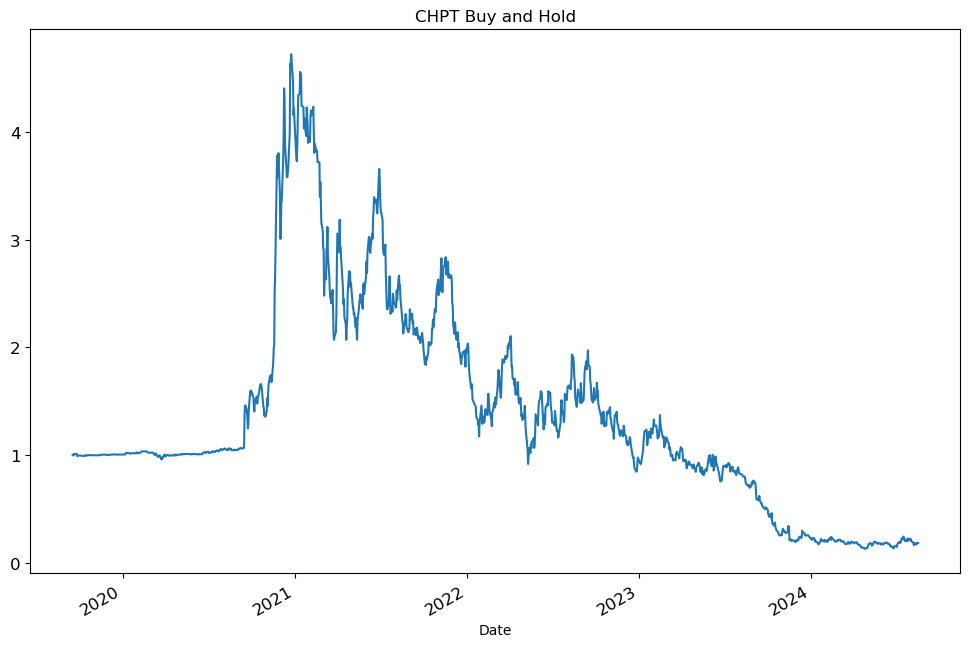

In [10]:
chpt.cumm_returns.plot(figsize=(12,8), title='CHPT Buy and Hold', fontsize=12)
plt.show()

In [11]:
chpt.d_returns.mean()*252

-0.345243424866151

In [12]:
chpt.d_returns.std()*np.sqrt(252)

0.7705551616320288

In [13]:
# Calculating draw downs (finding the peaks and valleys)
chpt['cumm_max'] = chpt.cumm_returns.cummax()

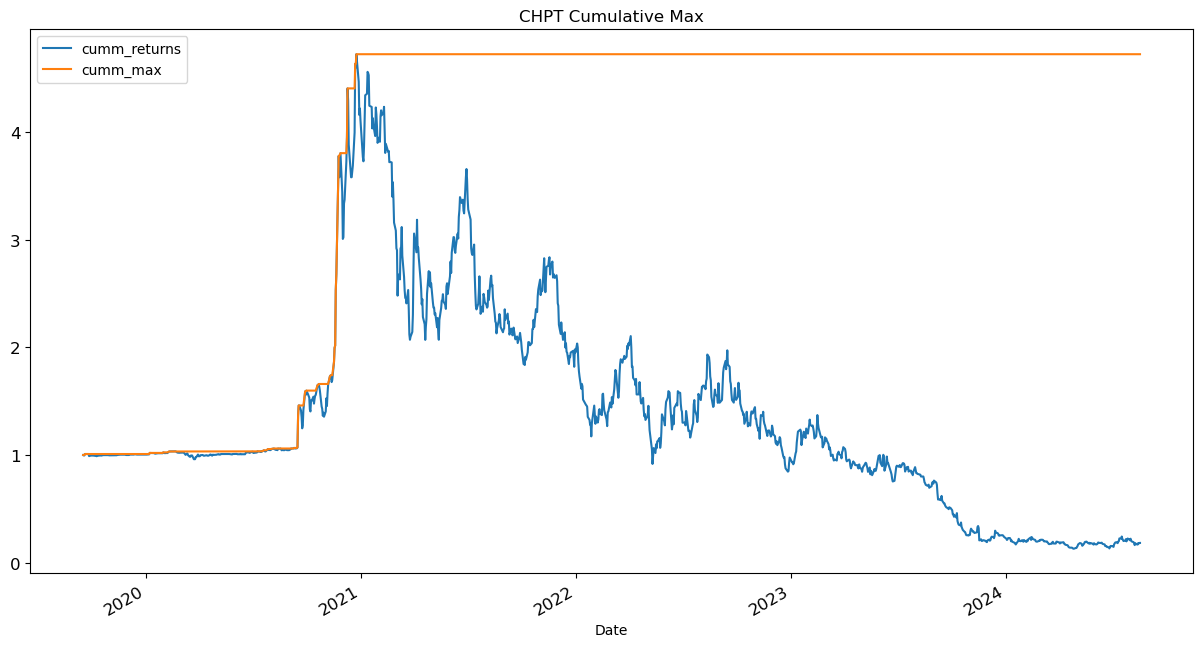

In [14]:
chpt[["cumm_returns","cumm_max"]].plot(figsize=(15,8), title='CHPT Cumulative Max', fontsize=12)
plt.show()

In [15]:
chpt['draw_down'] = chpt['cumm_max'] - chpt['cumm_returns']

In [16]:
chpt.draw_down.max()

4.594262031978967

In [17]:
chpt.draw_down.idxmax()

Timestamp('2024-04-25 00:00:00')

In [18]:
# Calculating drawdown percentage
chpt['draw_down_percentage'] = (chpt['cumm_max'] - chpt['cumm_returns']) / chpt['cumm_max']

In [19]:
chpt.draw_down_percentage.max()

0.9726681121004684

In [20]:
chpt.draw_down_percentage.idxmax()

Timestamp('2024-04-25 00:00:00')

In [21]:
chpt.loc[(chpt.index<='2023-11-30')]

Close  d_returns  cumm_returns  cumm_max  draw_down  \
Date                                                              
2019-09-17   9.76   0.000000      1.000000  1.000000   0.000000   
2019-09-18   9.72  -0.004107      0.995902  1.000000   0.004098   
2019-09-19   9.72   0.000000      0.995902  1.000000   0.004098   
2019-09-20   9.85   0.013286      1.009221  1.009221   0.000000   
2019-09-23   9.85   0.000000      1.009221  1.009221   0.000000   
...           ...        ...           ...       ...        ...   
2023-11-24   2.04   0.034916      0.209016  4.723360   4.514344   
2023-11-27   1.99  -0.024815      0.203893  4.723360   4.519467   
2023-11-28   1.93  -0.030615      0.197746  4.723360   4.525614   
2023-11-29   1.96   0.015425      0.200820  4.723360   4.522541   
2023-11-30   1.86  -0.052368      0.190574  4.723360   4.532787   

            draw_down_percentage  
Date                              
2019-09-17              0.000000  
2019-09-18              0.004098  
2019-09-19              0.004098  
2019-09-20              0.000000  
2019-09-23              0.000000  
...                          ...  
2023-11-24              0.955748  
2023-11-27              0.956833  
2023-11-28              0.958134  
2023-11-29              0.957484  
2023-11-30              0.959653  

[1060 rows x 6 columns]

## SMA Strategy (CHPT)

In [22]:
data = chpt.Close.loc[(chpt.index>='1991-01-01')]
data = data.to_frame()

In [23]:
# moving averages

sma_s = 25
sma_l = 50


data['sma_s'] = data.Close.rolling(sma_s).mean()
data['sma_l'] = data.Close.rolling(sma_l).mean()

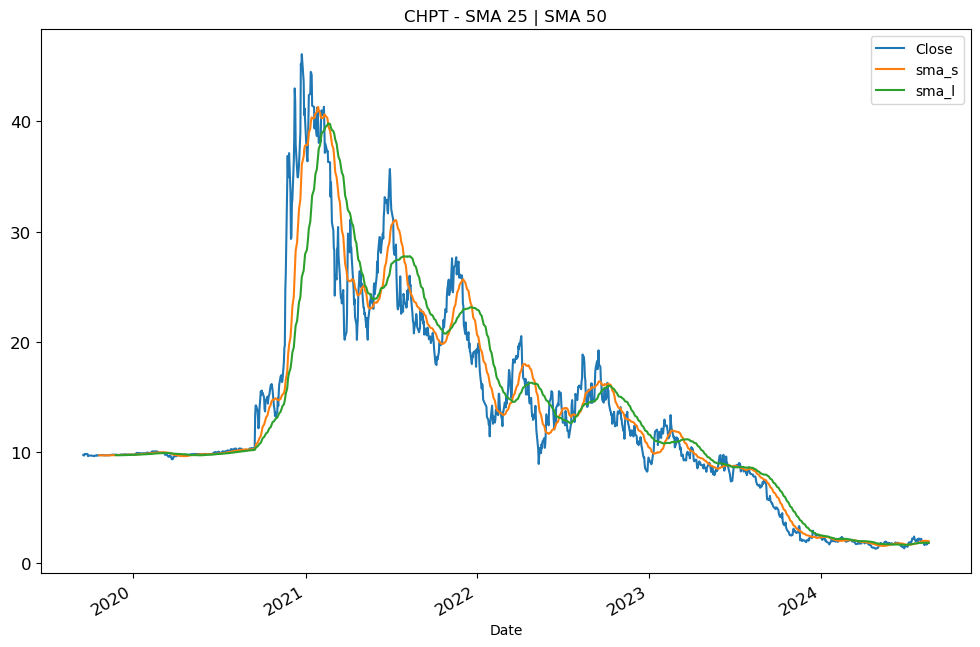

In [24]:
data.plot(figsize=(12,8), title='CHPT - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12);

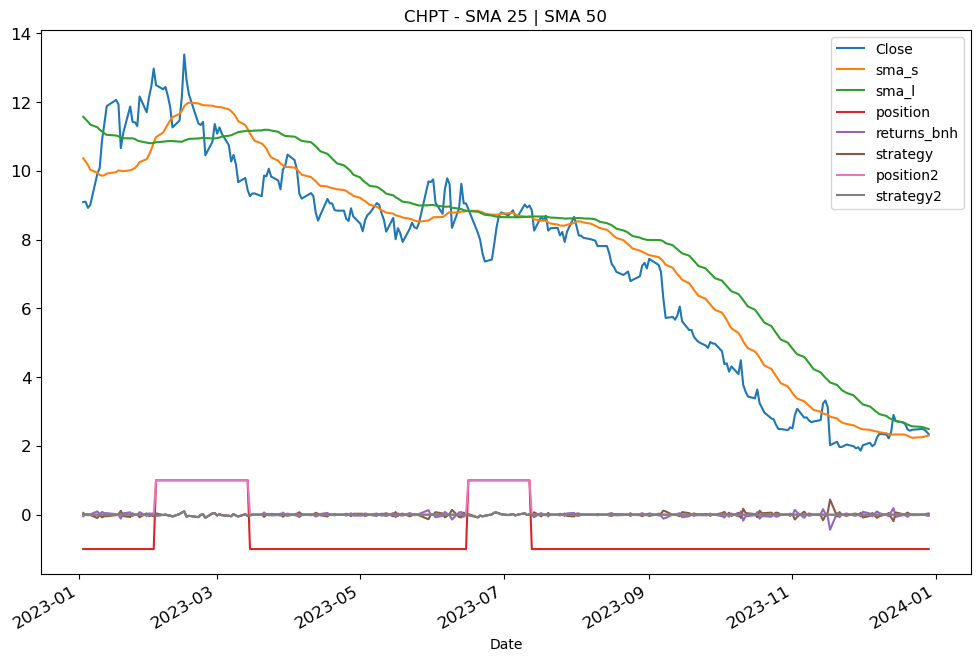

In [50]:
data.loc['2023'].plot(figsize=(12,8), title='CHPT - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12);
data.dropna(inplace=True)

In [26]:
data['position'] = np.where(data['sma_s']>data['sma_l'], 1, -1)
data

Close   sma_s   sma_l  position
Date                                       
2019-11-25   9.79  9.7528  9.7445         1
2019-11-26   9.79  9.7544  9.7451         1
2019-11-27   9.79  9.7560  9.7465         1
2019-11-29   9.76  9.7564  9.7473         1
2019-12-02   9.76  9.7568  9.7455         1
...           ...     ...     ...       ...
2024-08-12   1.64  1.9736  1.7986         1
2024-08-13   1.78  1.9740  1.8006         1
2024-08-14   1.74  1.9672  1.8024         1
2024-08-15   1.79  1.9612  1.8046         1
2024-08-16   1.79  1.9448  1.8058         1

[1189 rows x 4 columns]

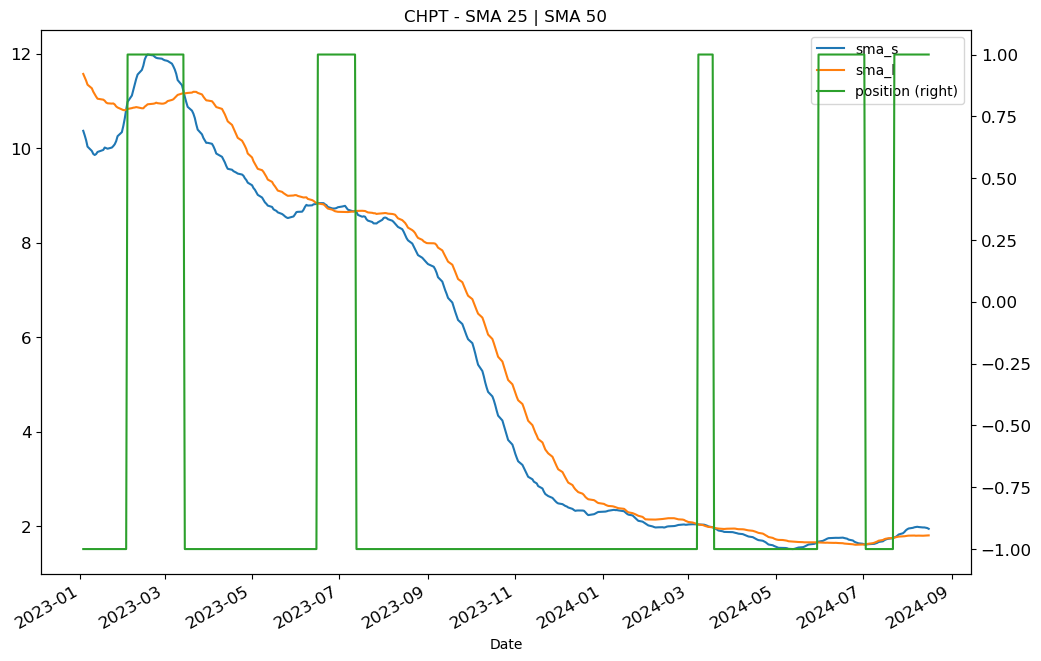

In [51]:
data.loc['2023':'2024',["sma_s", "sma_l",'position']].plot(figsize=(12,8), title='CHPT - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12,secondary_y='position');

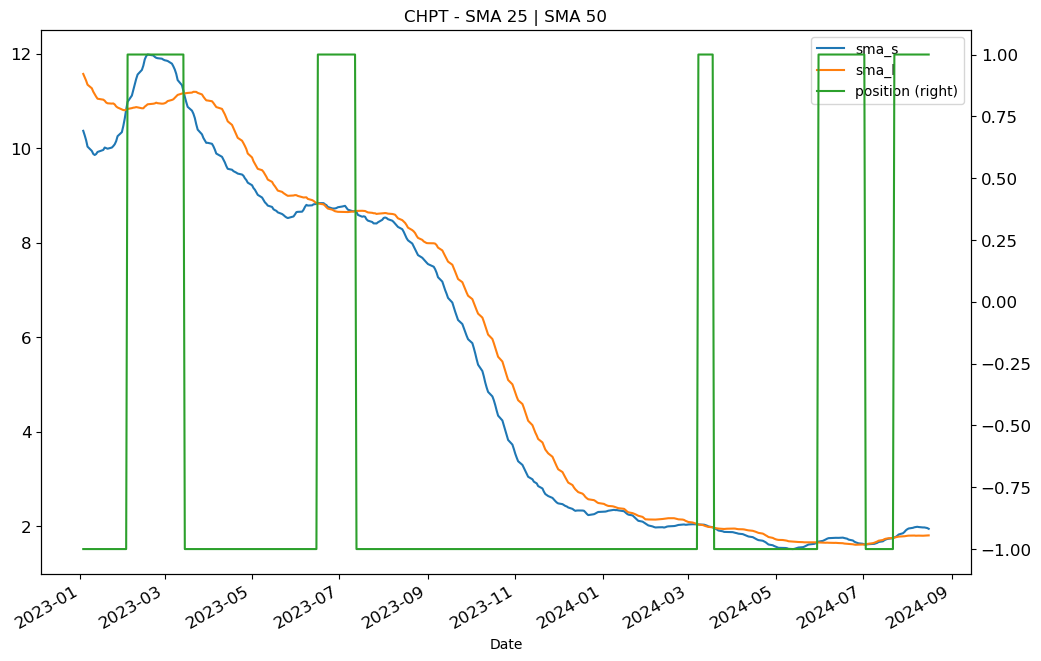

In [52]:
data.loc['2023':'2024',["sma_s", "sma_l",'position']].plot(figsize=(12,8), title='CHPT - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12,secondary_y='position');

In [53]:
# buy and hold column
data['returns_bnh'] = np.log(data.Close.div(data.Close.shift(1)))

In [54]:
# strategy column
data['strategy'] = data['returns_bnh'] * data.position.shift(1)
data.dropna(inplace=True)

In [55]:
data[['returns_bnh','strategy']].sum()

returns_bnh   -1.699146
strategy       1.262826
dtype: float64

In [56]:
data[['returns_bnh','strategy']].sum().apply(np.exp)

returns_bnh    0.182840
strategy       3.535399
dtype: float64

In [57]:
data[['returns_bnh','strategy']].std()*np.sqrt(252) # annual std

returns_bnh    0.787168
strategy       0.787315
dtype: float64

### Strategy 2

In [34]:
data['position2'] = np.where(data['sma_s']>data['sma_l'], 1, 0)
data['strategy2'] = data['returns_bnh'] * data.position2.shift(1)
data.dropna(inplace=True)

In [35]:
data[['returns_bnh','strategy2']].sum()

returns_bnh   -1.699146
strategy2     -0.218160
dtype: float64

In [36]:
data[['returns_bnh','strategy2']].sum().apply(np.exp)

returns_bnh    0.182840
strategy2      0.803997
dtype: float64

In [37]:
data[['returns_bnh','strategy2']].std()*np.sqrt(252) # risk

returns_bnh    0.786836
strategy2      0.481609
dtype: float64

In [38]:
data[['strategy','strategy2']].std()*np.sqrt(252) # risk

strategy     0.786983
strategy2    0.481609
dtype: float64

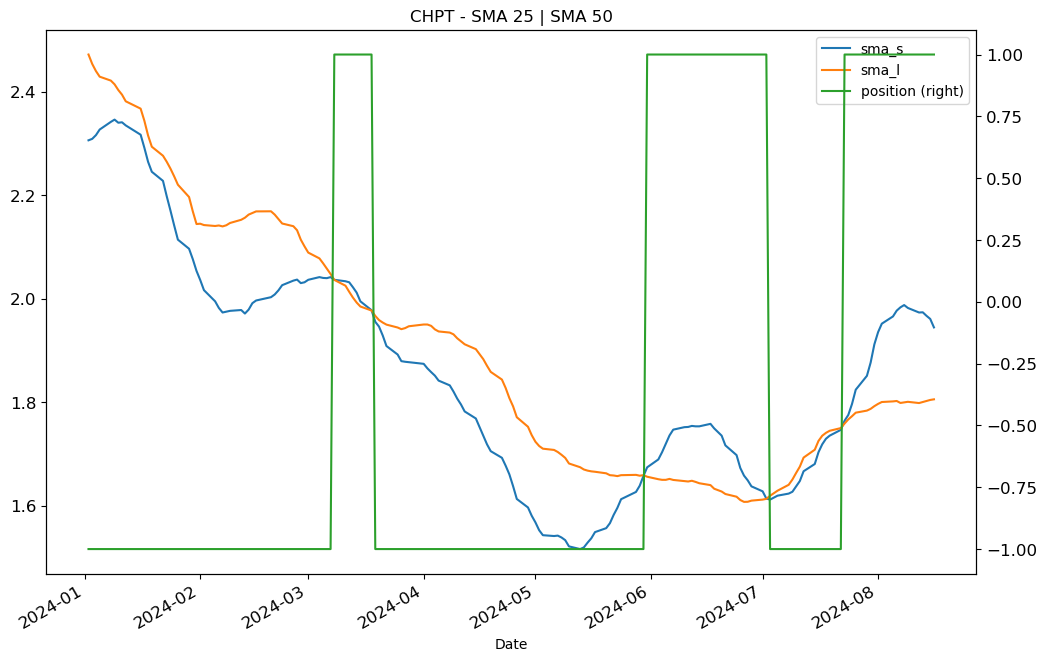

In [58]:
data.loc['2024',["sma_s", "sma_l",'position']].plot(figsize=(12,8), title='CHPT - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12,secondary_y='position');

# Function

In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def combined_analysis(stock_symbol, sma_short=25, sma_long=50, bb_window=20, bb_num_std=2, rsi_window=14,
                      macd_short_window=12, macd_long_window=26, macd_signal_window=9,
                      start_date=None, end_date=None):
    # Download stock data
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Extract closing prices
    stock_close = stock_data['Close'].to_frame()

    # Calculate daily returns
    stock_close['d_returns'] = np.log(stock_close.div(stock_close.shift(1)))
    stock_close.dropna(inplace=True)

    # Calculate cumulative returns
    stock_close['cumm_returns'] = stock_close['d_returns'].cumsum().apply(np.exp)

    # Plot cumulative returns
    stock_close['cumm_returns'].plot(figsize=(12, 8), title=f'{stock_symbol} Buy and Hold', fontsize=12)
    plt.show()

    # Simple Moving Average (SMA) Strategy
    stock_close['sma_short'] = stock_close['Close'].rolling(sma_short).mean()
    stock_close['sma_long'] = stock_close['Close'].rolling(sma_long).mean()

    # Generate buy and sell signals
    stock_close['position'] = np.where(stock_close['sma_short'] > stock_close['sma_long'], 1, -1)

    # Plot SMA strategy
    stock_close[['Close', 'sma_short', 'sma_long']].plot(figsize=(12, 8), title=f'{stock_symbol} - SMA {sma_short} | SMA {sma_long}', fontsize=12)
    plt.show()

    # Plot buy and sell positions
    stock_close['position'].plot(ylim=[-1.1, 1.1], figsize=(12, 8), title=f'{stock_symbol} - Buy and Sell Positions', fontsize=12)
    plt.show()

    # Bollinger Bands Analysis
    stock_close['sma'] = stock_close['Close'].rolling(bb_window).mean()
    stock_close['upper_band'] = stock_close['sma'] + (bb_num_std * stock_close['Close'].rolling(bb_window).std())
    stock_close['lower_band'] = stock_close['sma'] - (bb_num_std * stock_close['Close'].rolling(bb_window).std())

    # Plot Bollinger Bands
    stock_close[['Close', 'sma', 'upper_band', 'lower_band']].plot(figsize=(12, 8), title=f'{stock_symbol} - Bollinger Bands', fontsize=12)
    plt.show()

    # RSI Analysis
    delta = stock_close['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(rsi_window).mean()
    avg_loss = loss.rolling(rsi_window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Plot RSI
    rsi.plot(figsize=(12, 8), title=f'{stock_symbol} - Relative Strength Index (RSI)', fontsize=12)
    plt.axhline(70, color='r', linestyle='--', label='Overbought (70)')
    plt.axhline(30, color='g', linestyle='--', label='Oversold (30)')
    plt.legend()
    plt.show()

    # MACD Analysis
    stock_close['short_ema'] = stock_close['Close'].ewm(span=macd_short_window, adjust=False).mean()
    stock_close['long_ema'] = stock_close['Close'].ewm(span=macd_long_window, adjust=False).mean()
    stock_close['macd'] = stock_close['short_ema'] - stock_close['long_ema']
    stock_close['signal'] = stock_close['macd'].ewm(span=macd_signal_window, adjust=False).mean()

    # Plot MACD
    stock_close[['Close', 'macd', 'signal']].plot(figsize=(12, 8), title=f'{stock_symbol} - Moving Average Convergence Divergence (MACD)', fontsize=12)
    plt.show()

    # Calculate and Print Risk and Return
    total_return = stock_close['cumm_returns'][-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(stock_close.index)) - 1
    annualized_volatility = stock_close['d_returns'].std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    print(f'Total Return: {total_return:.2%}')
    print(f'Annualized Return: {annualized_return:.2%}')
    print(f'Annualized Volatility: {annualized_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

    # Calculate and Print Profit/Loss
    buy_signals = stock_close[stock_close['position'] == 1]
    sell_signals = stock_close[stock_close['position'] == -1]

    for buy_index, sell_index in zip(buy_signals.index, sell_signals.index):
        buy_price = stock_close['Close'].loc[buy_index]
        sell_price = stock_close['Close'].loc[sell_index]
        quantity = 1  # You can modify this based on

# Results

[*********************100%***********************]  1 of 1 completed


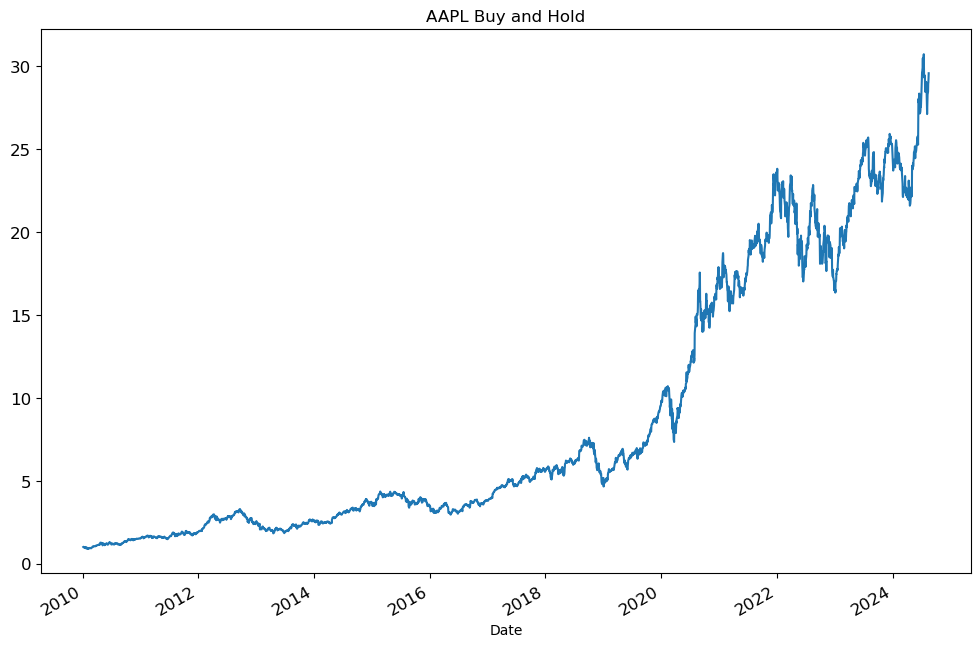

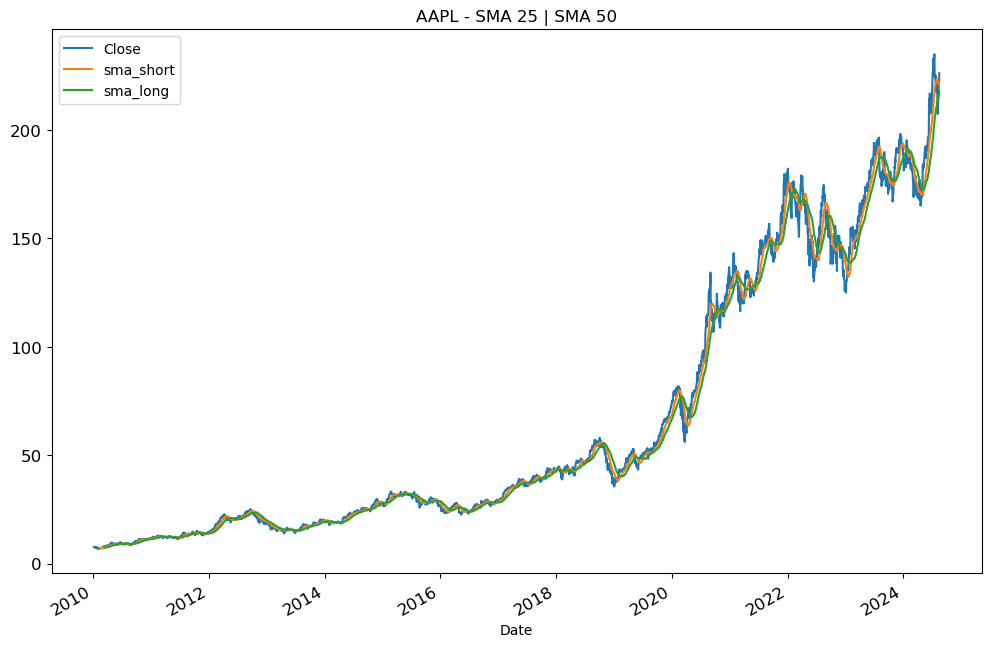

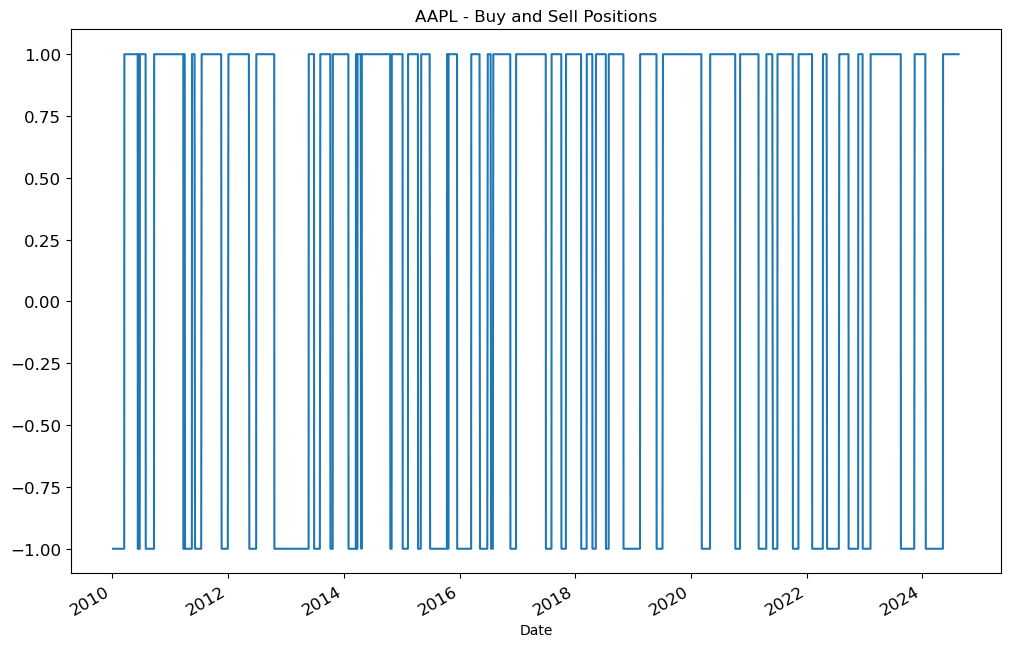

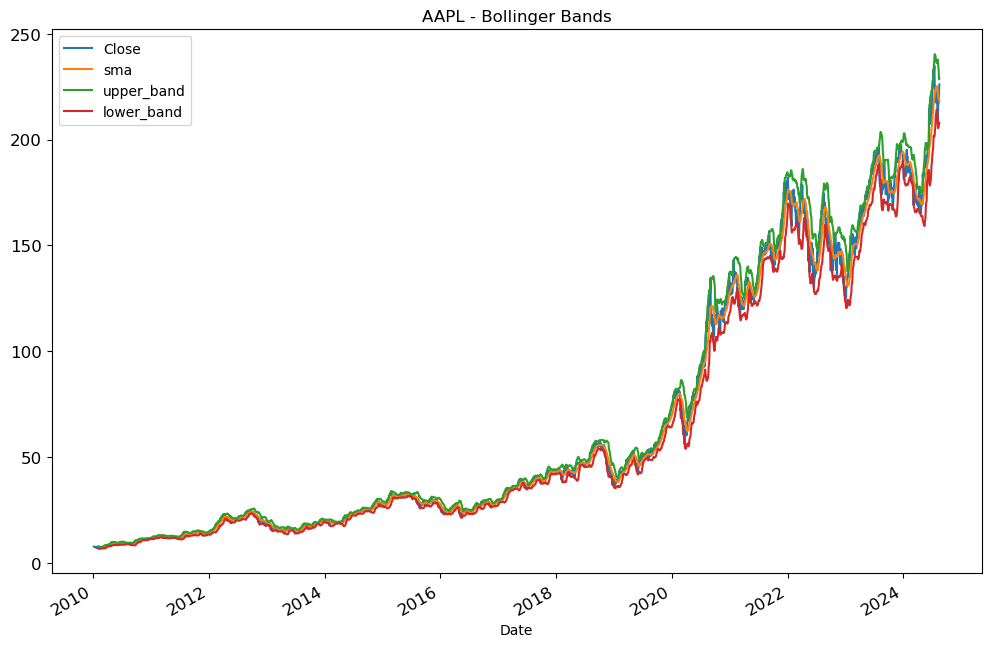

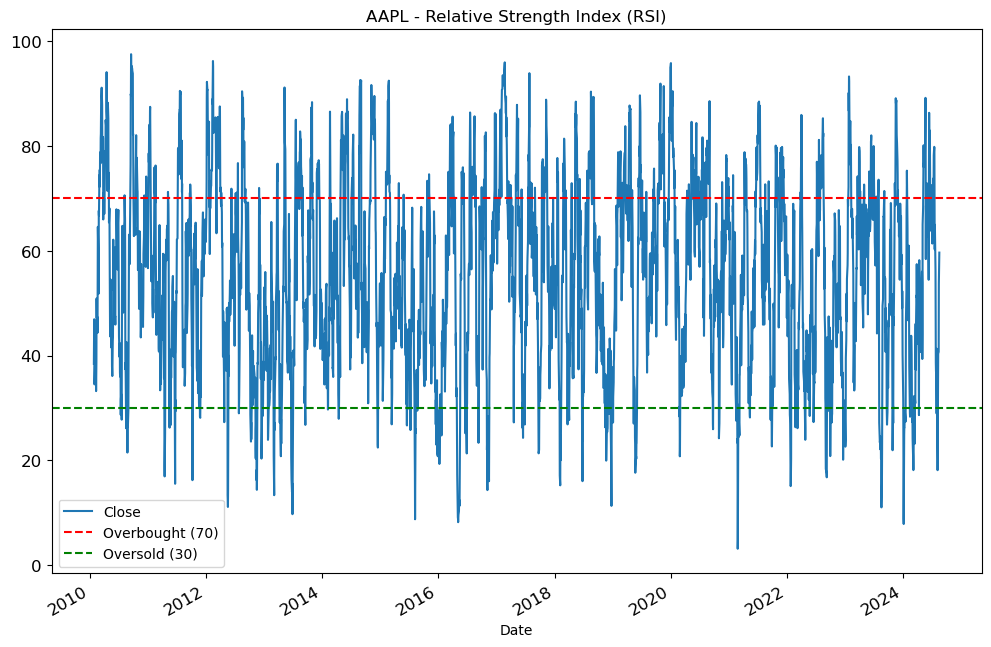

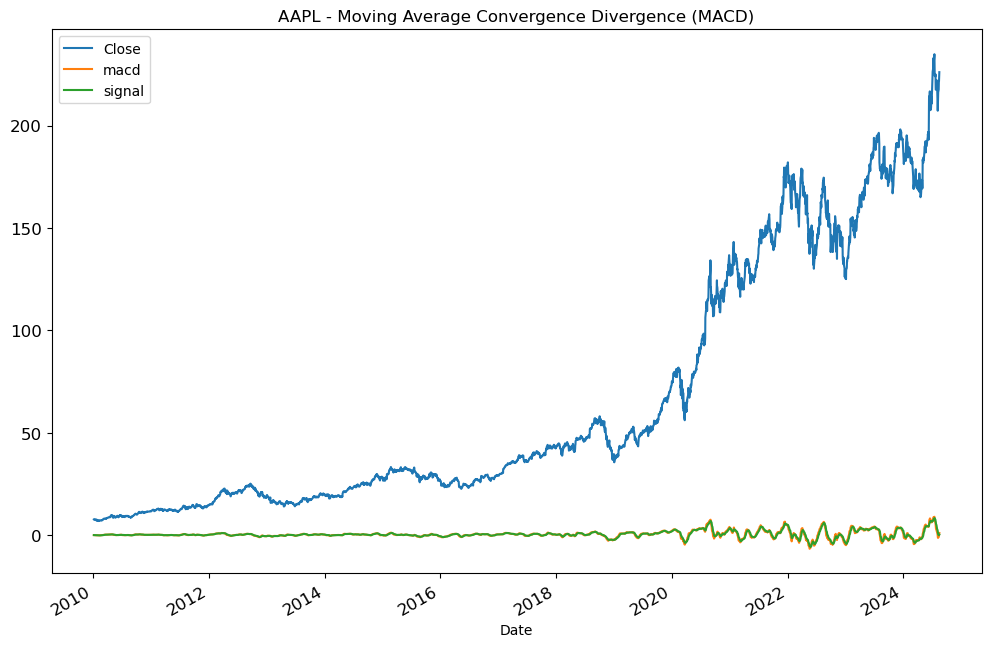

Total Return: 2857.53%
Annualized Return: 26.11%
Annualized Volatility: 28.09%
Sharpe Ratio: 0.93


In [59]:
combined_analysis('AAPL', start_date='2010-01-01', end_date='2024-12-31')

[*********************100%***********************]  1 of 1 completed


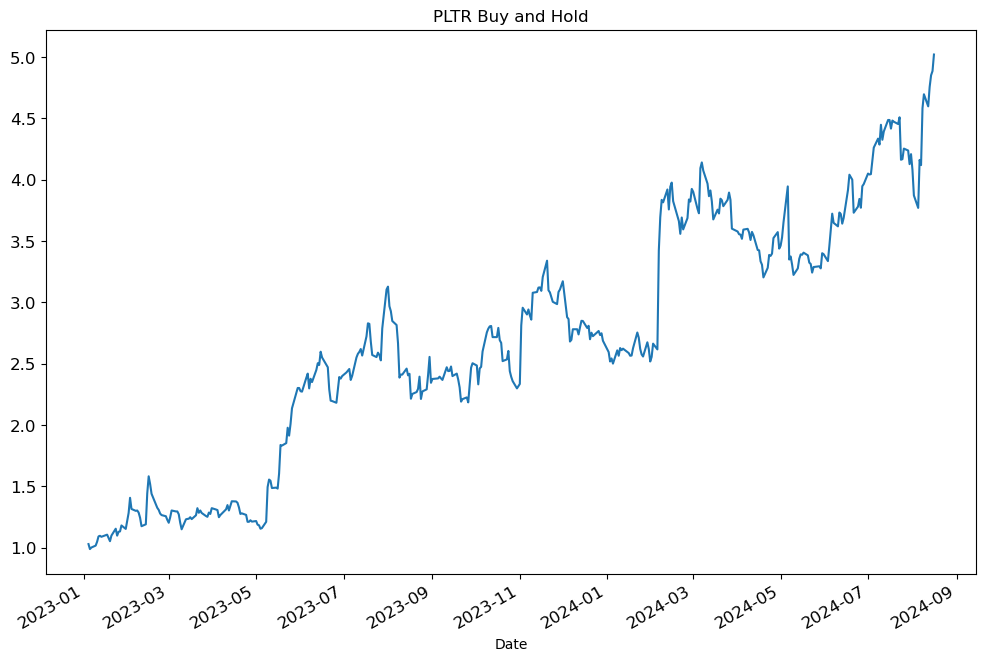

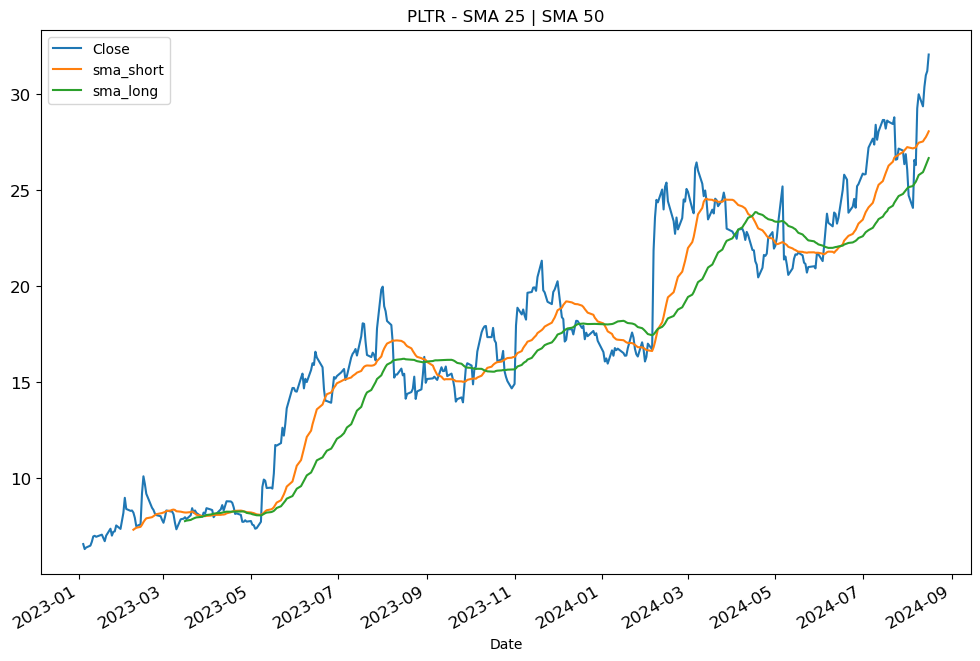

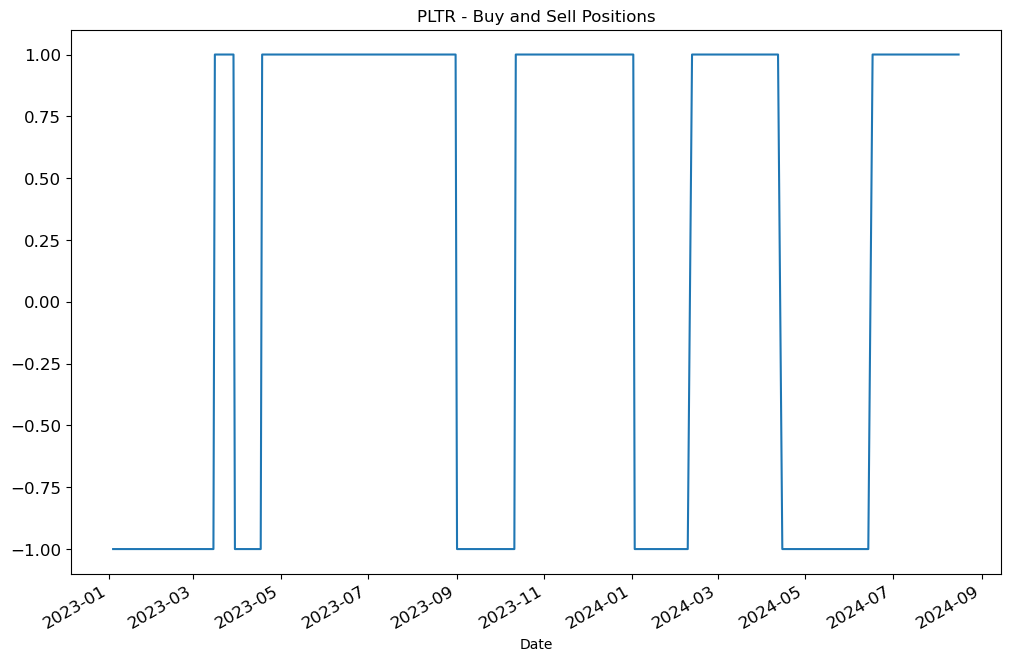

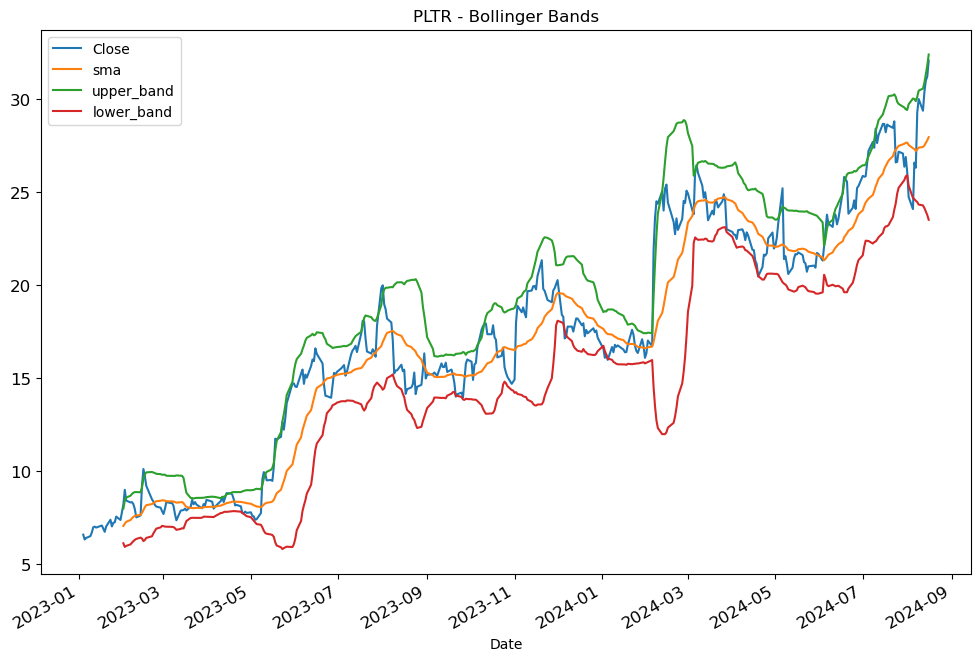

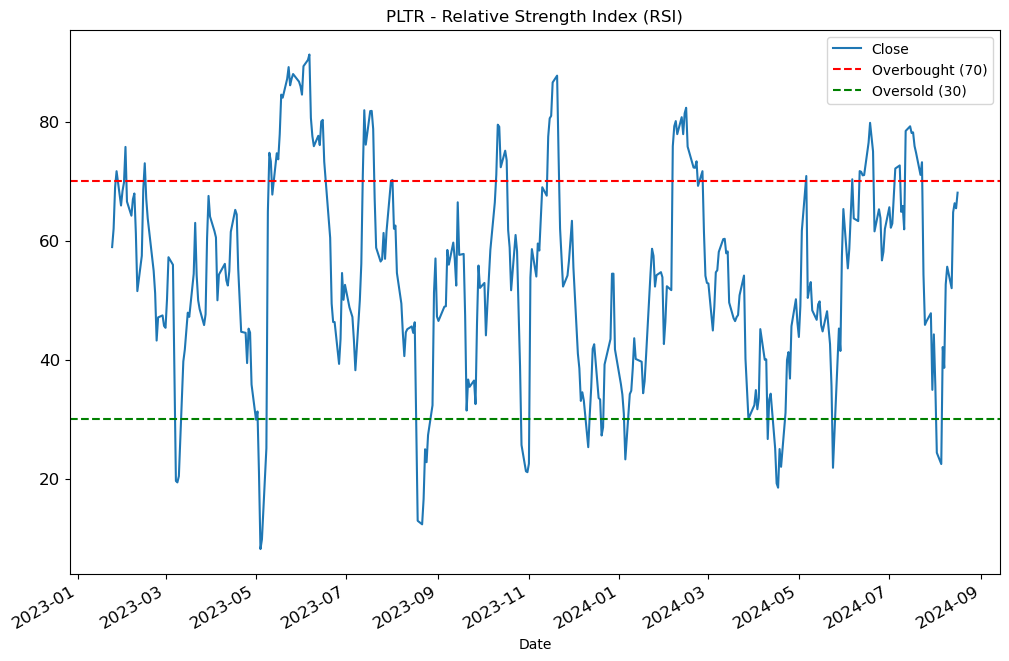

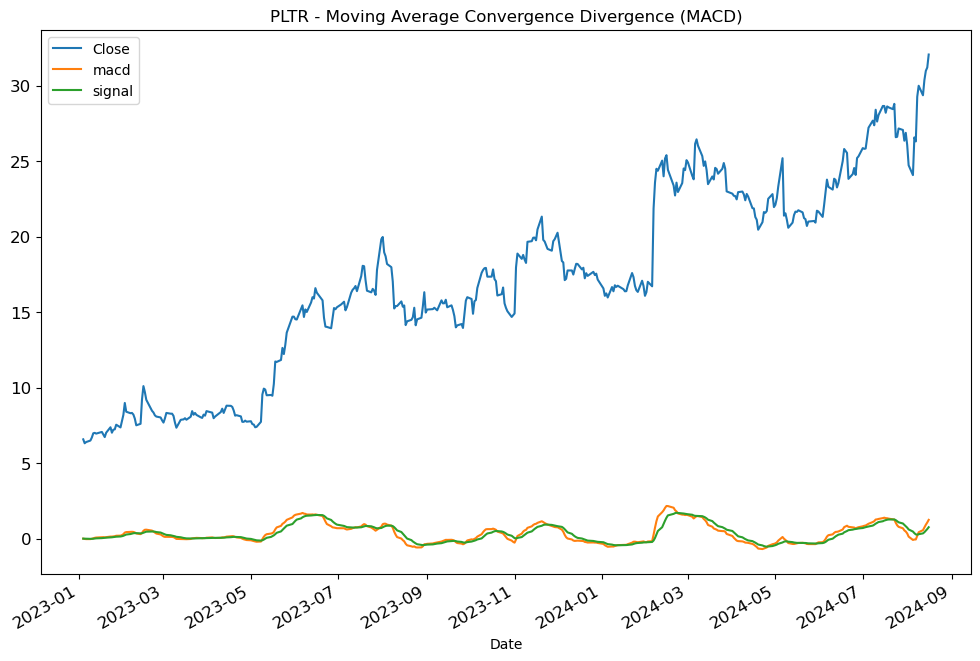

Total Return: 402.03%
Annualized Return: 171.56%
Annualized Volatility: 65.19%
Sharpe Ratio: 2.63


In [60]:
combined_analysis('PLTR', start_date='2023-01-01', end_date='2024-12-31')

[*********************100%***********************]  1 of 1 completed


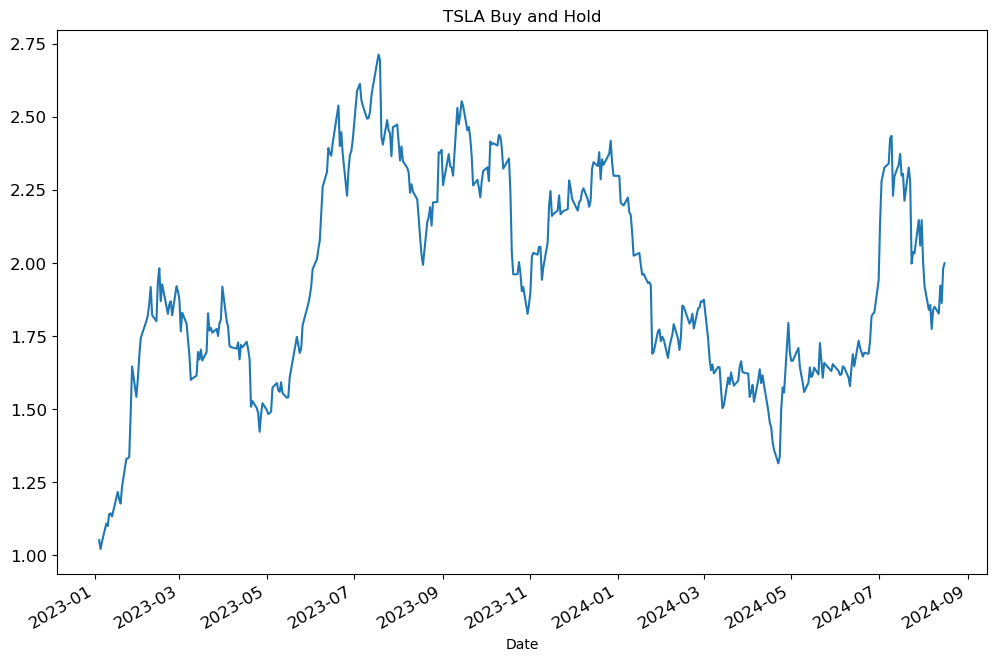

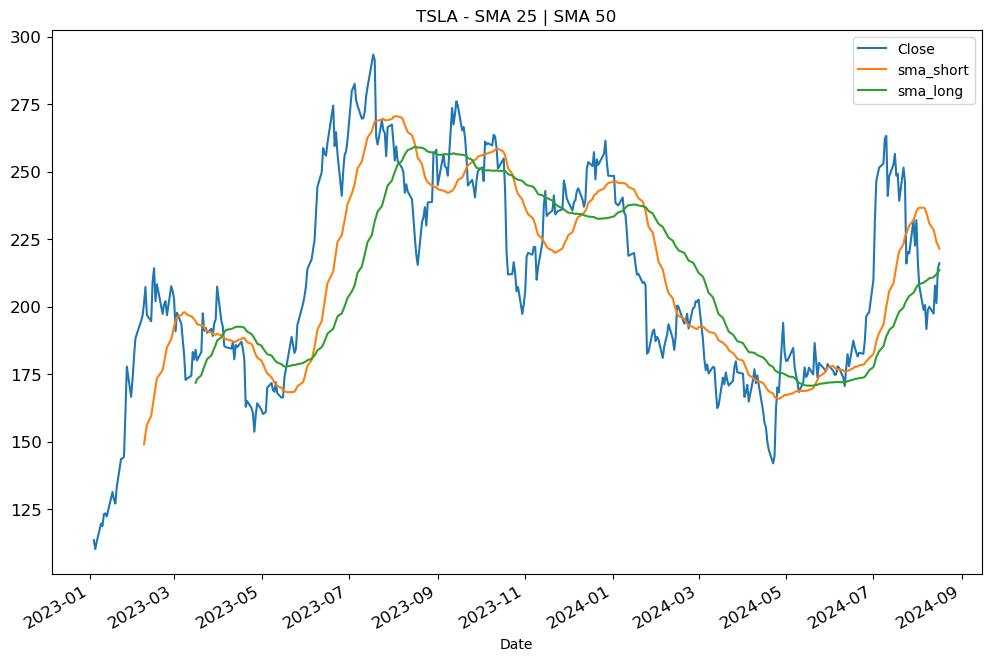

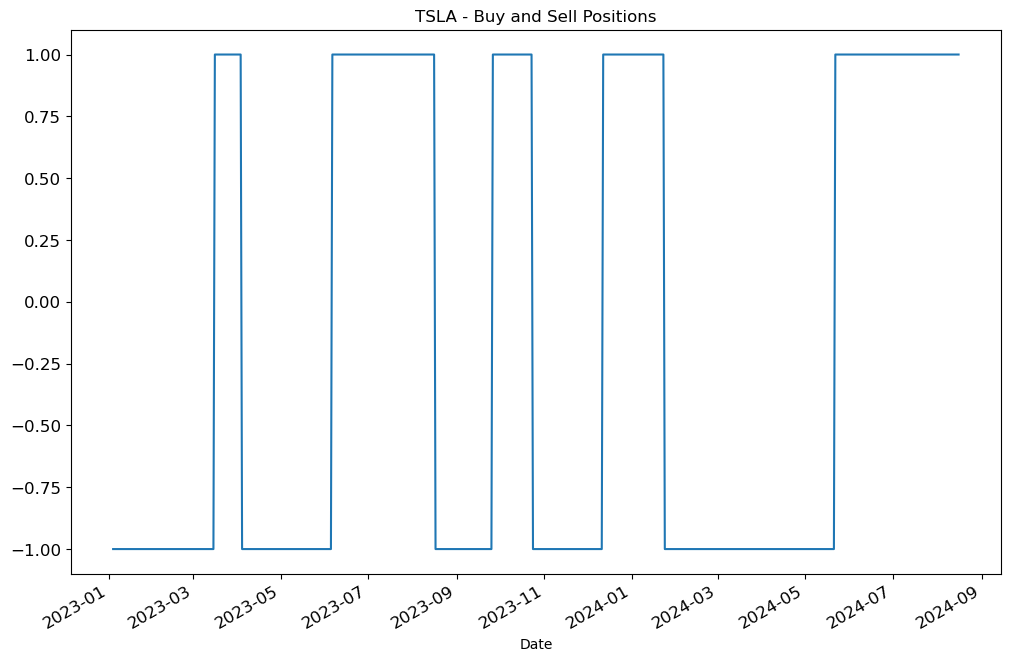

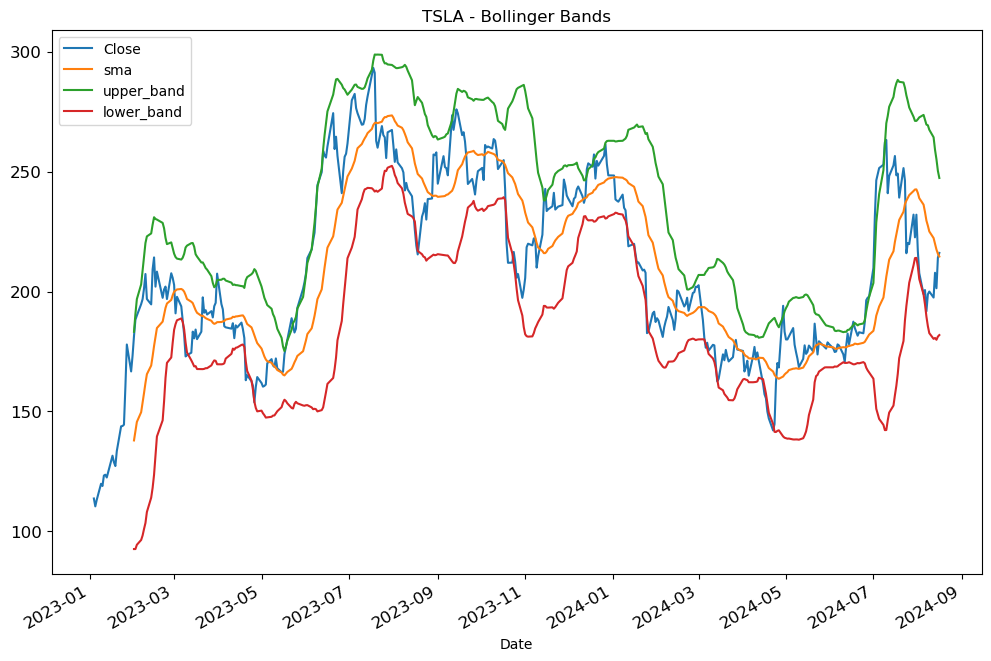

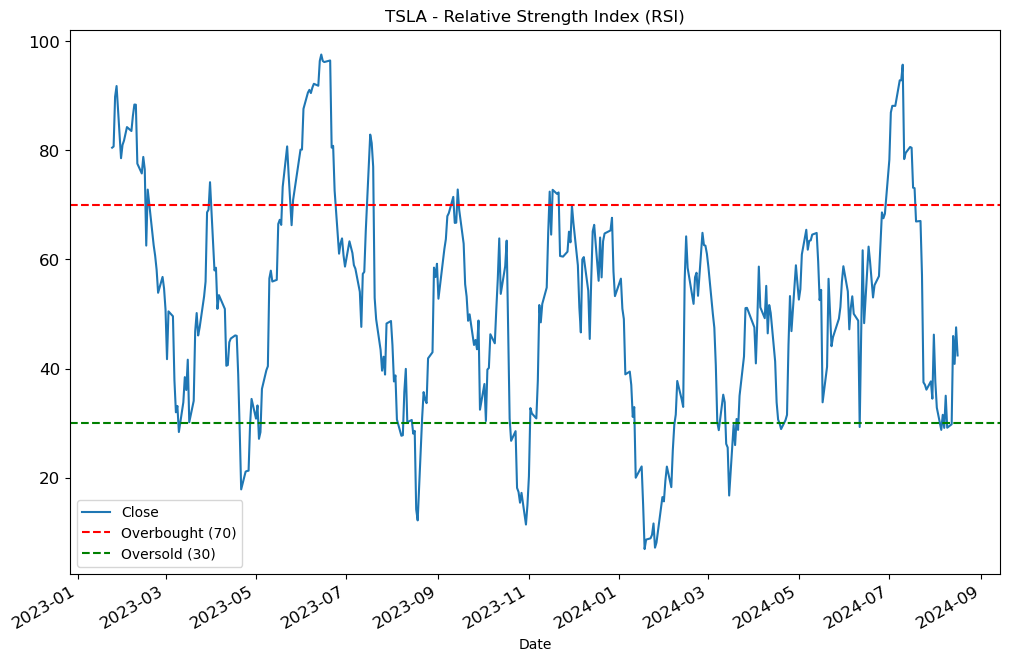

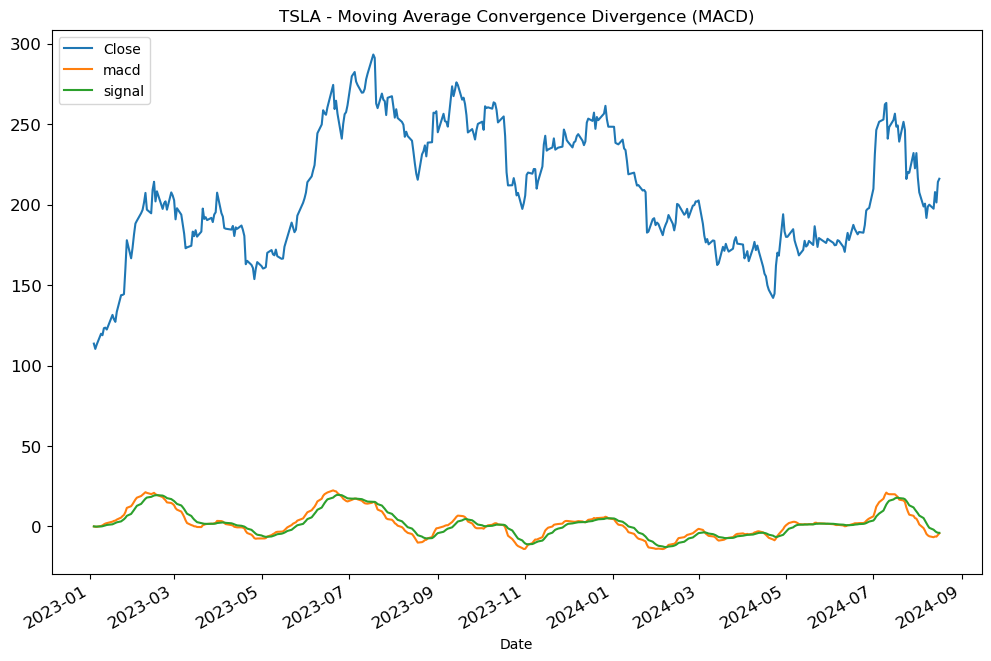

Total Return: 99.93%
Annualized Return: 53.56%
Annualized Volatility: 54.75%
Sharpe Ratio: 0.98


In [61]:
combined_analysis('TSLA', start_date='2023-01-01', end_date='2024-12-31')

[*********************100%***********************]  1 of 1 completed


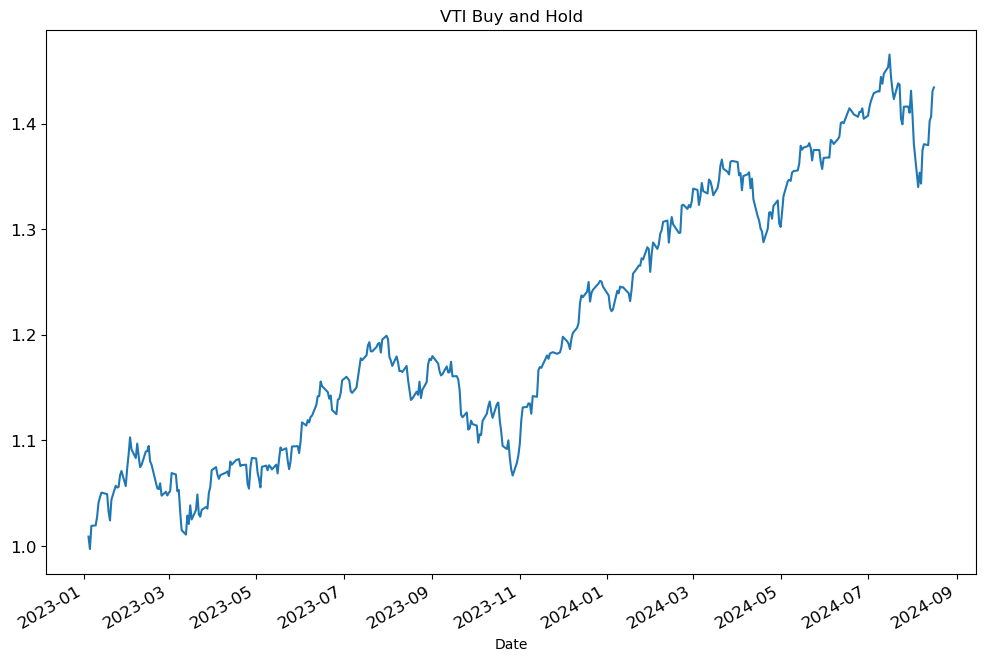

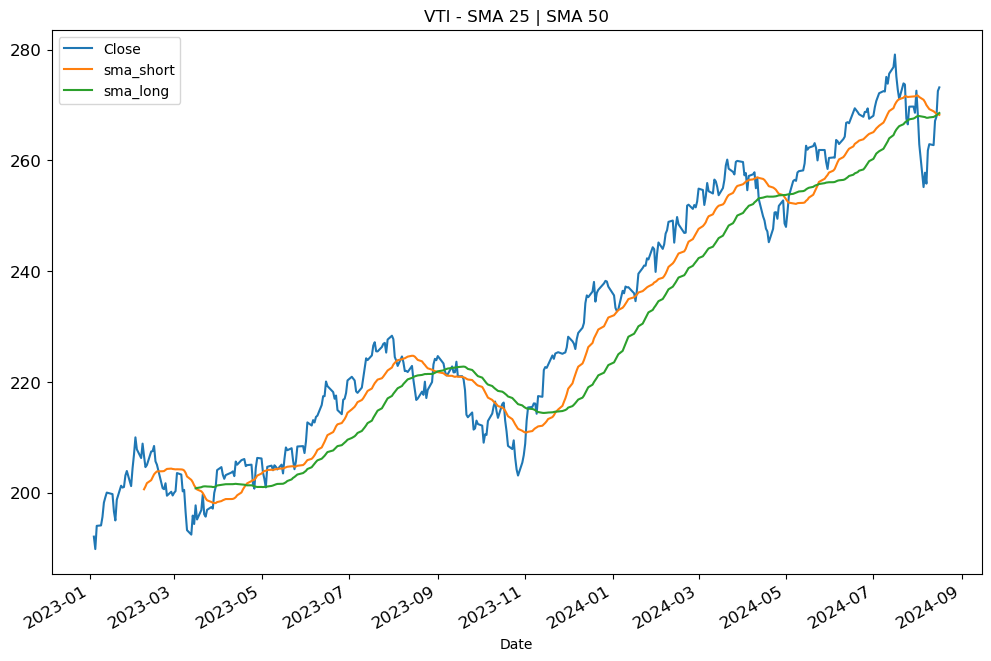

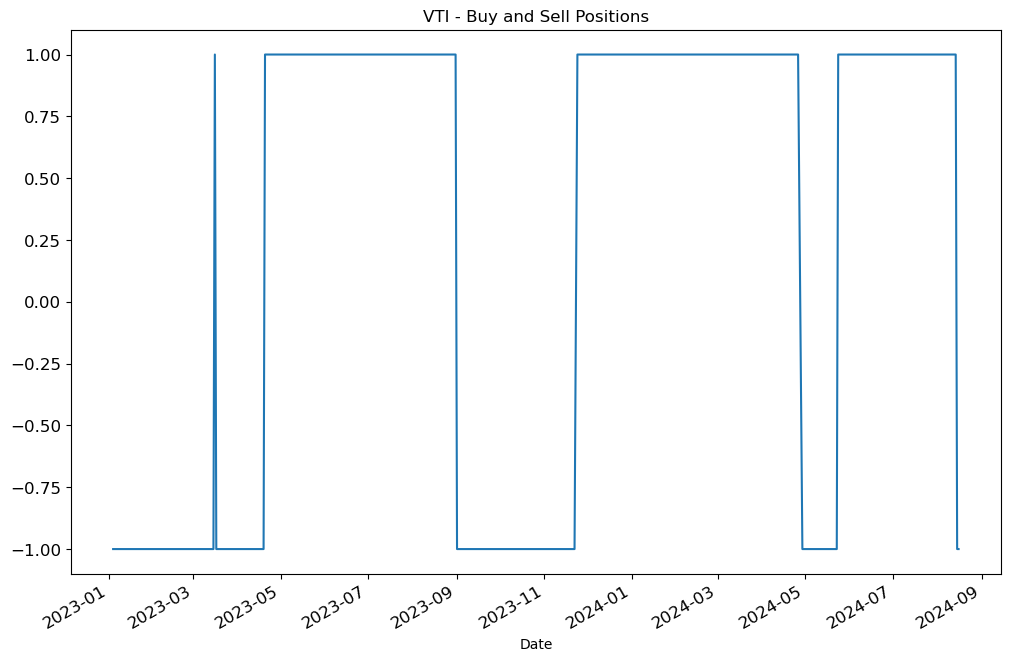

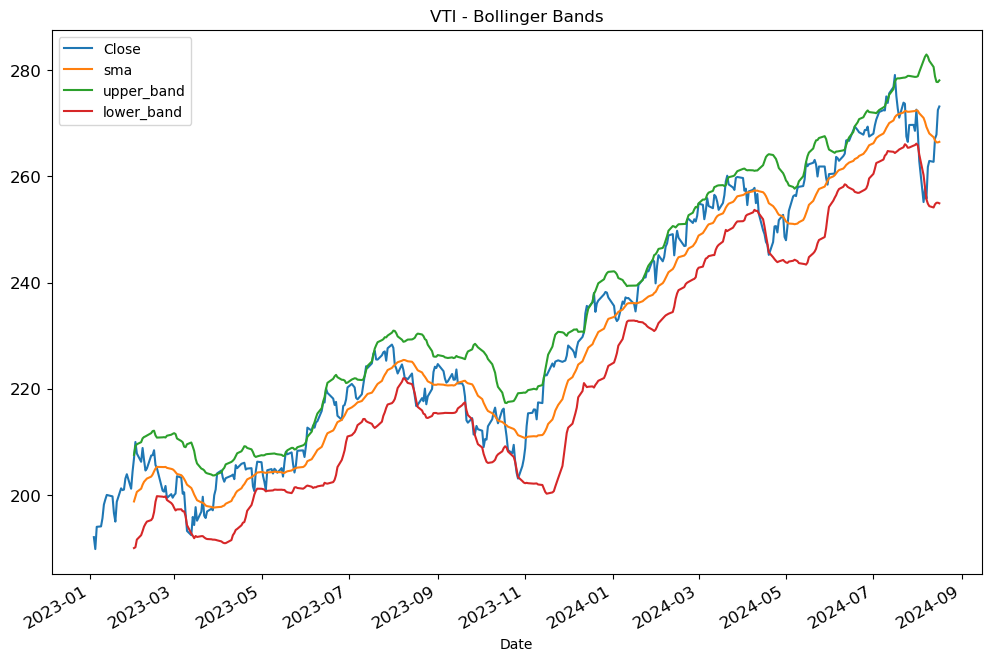

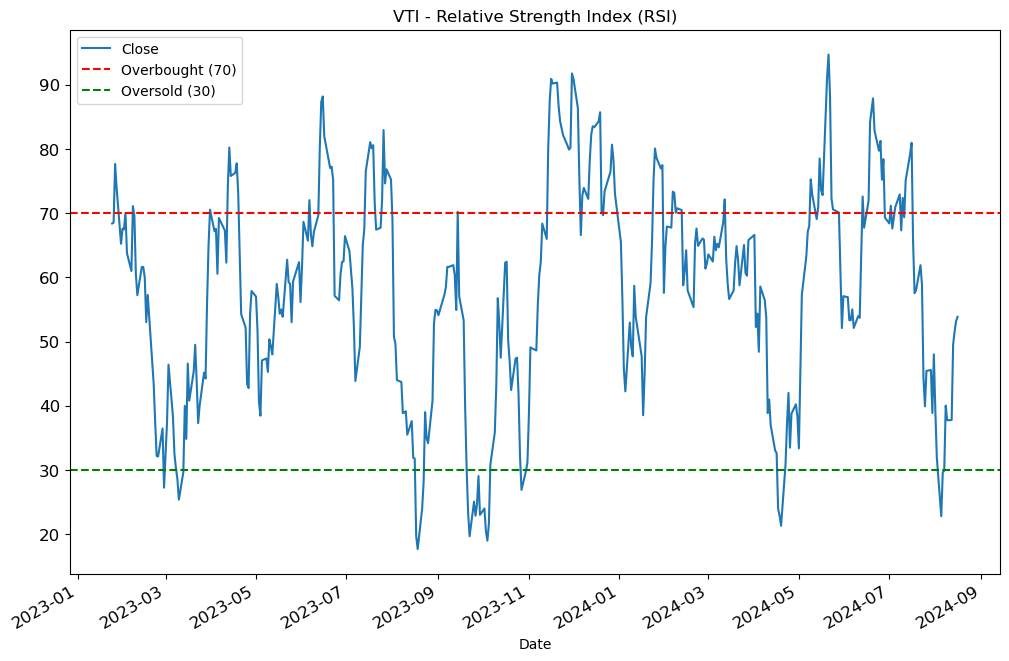

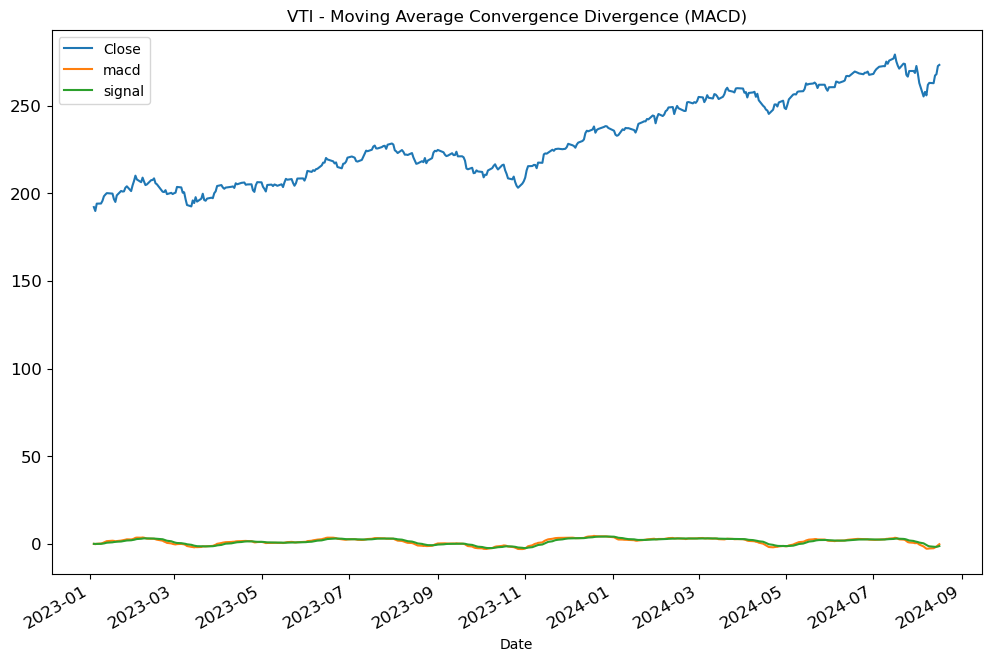

Total Return: 43.46%
Annualized Return: 25.04%
Annualized Volatility: 13.34%
Sharpe Ratio: 1.88


In [62]:
combined_analysis('VTI', start_date='2023-01-01', end_date='2024-12-31')

[*********************100%***********************]  1 of 1 completed


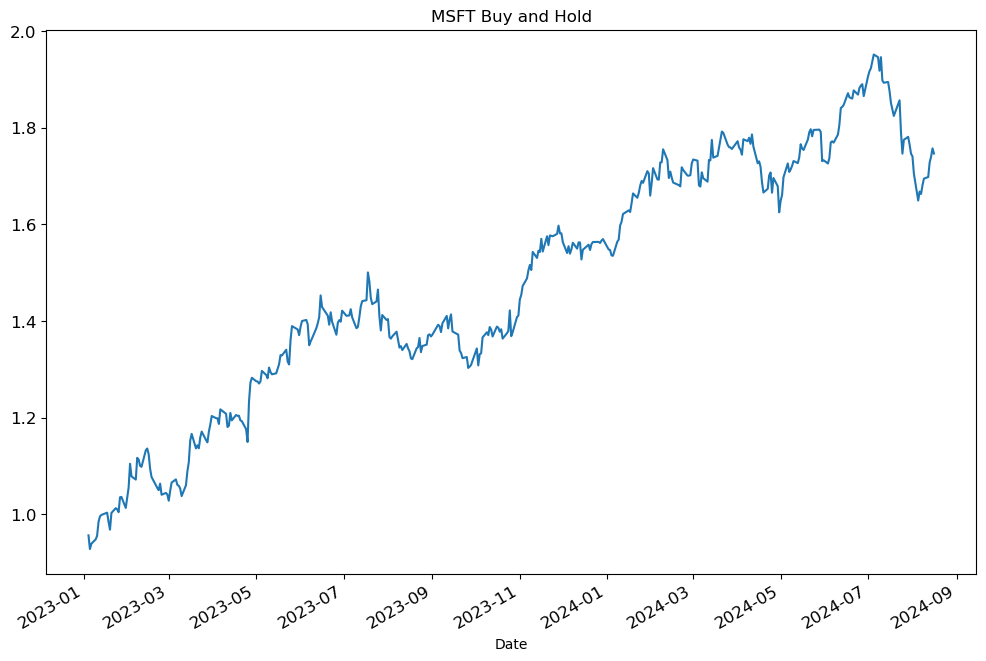

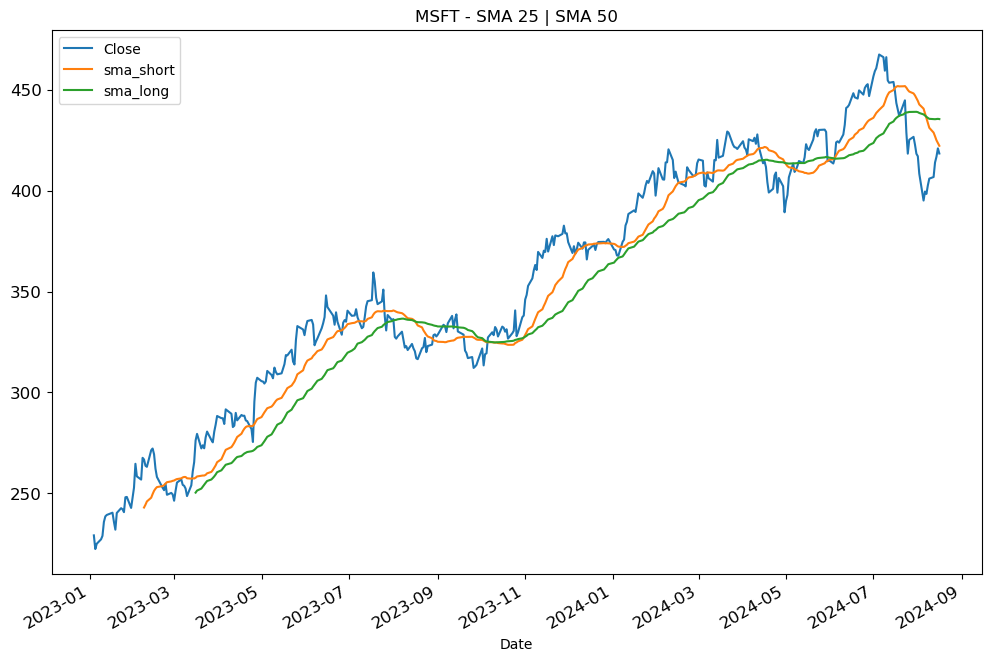

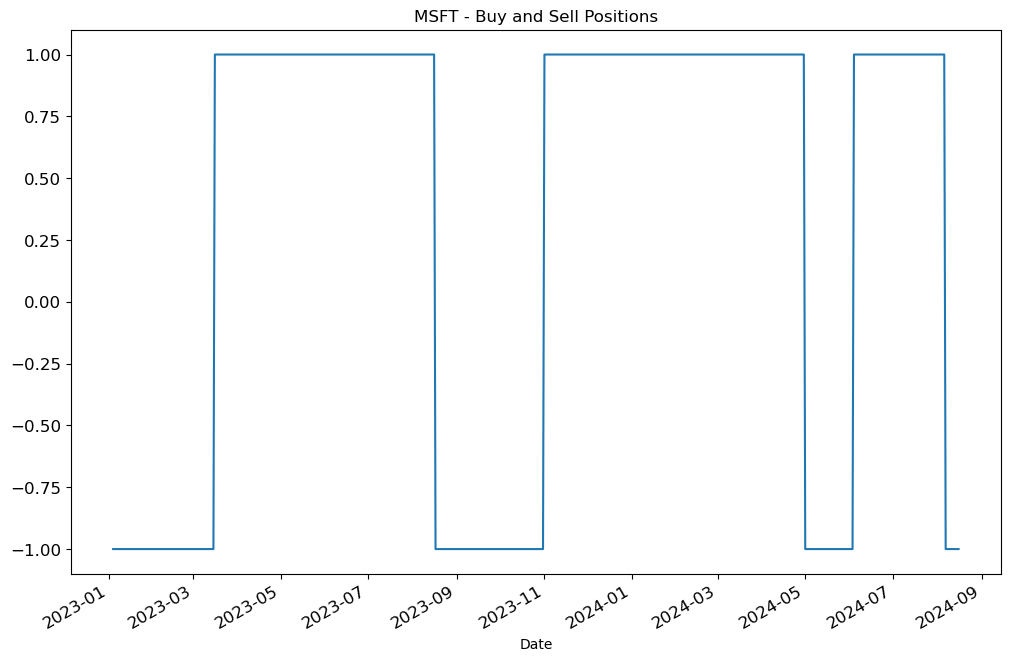

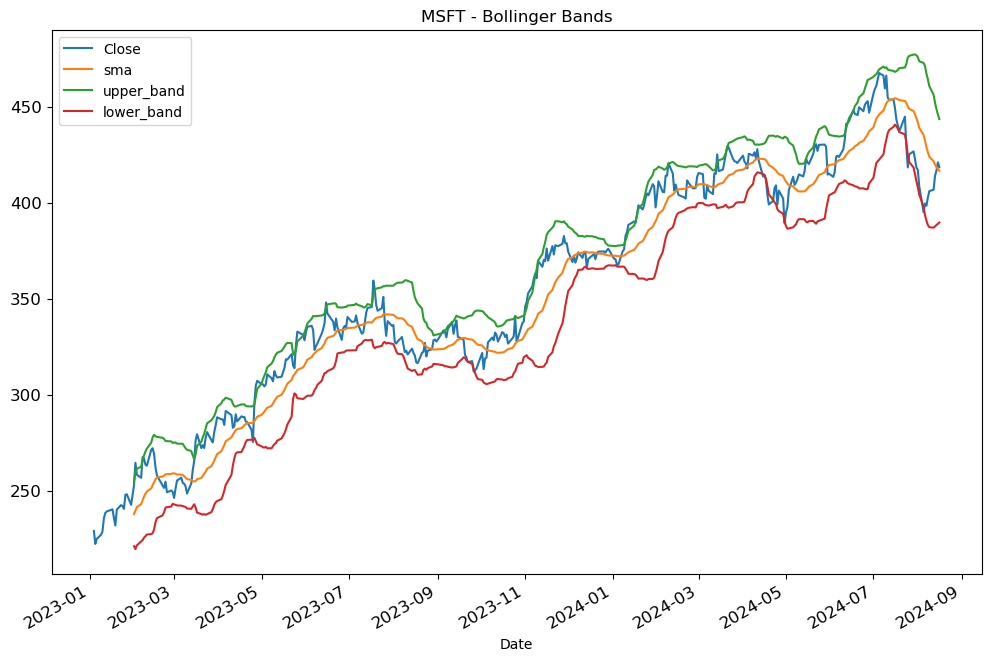

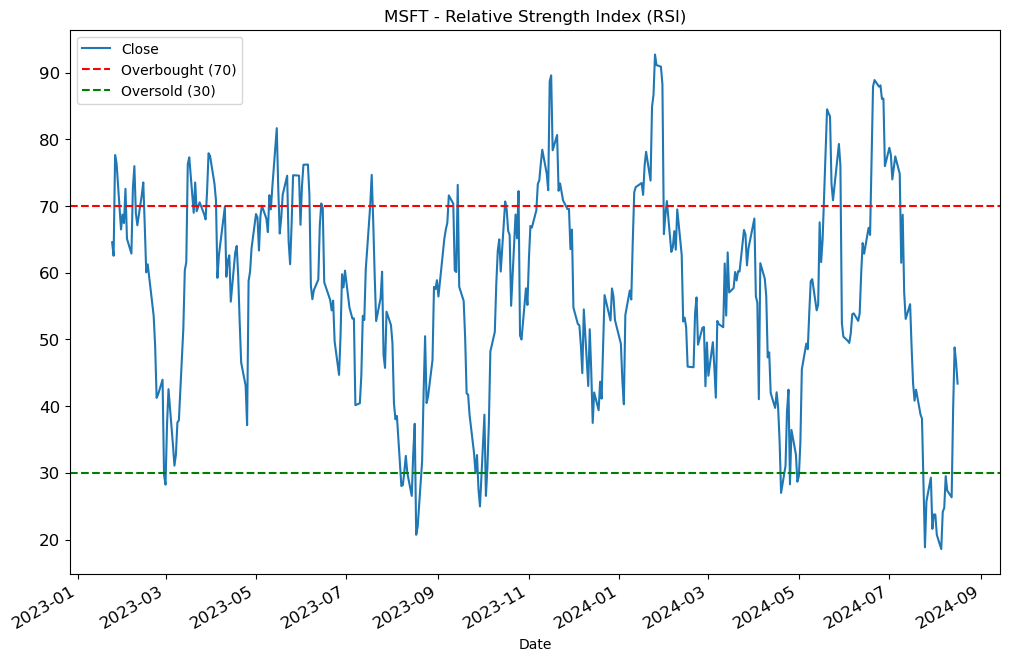

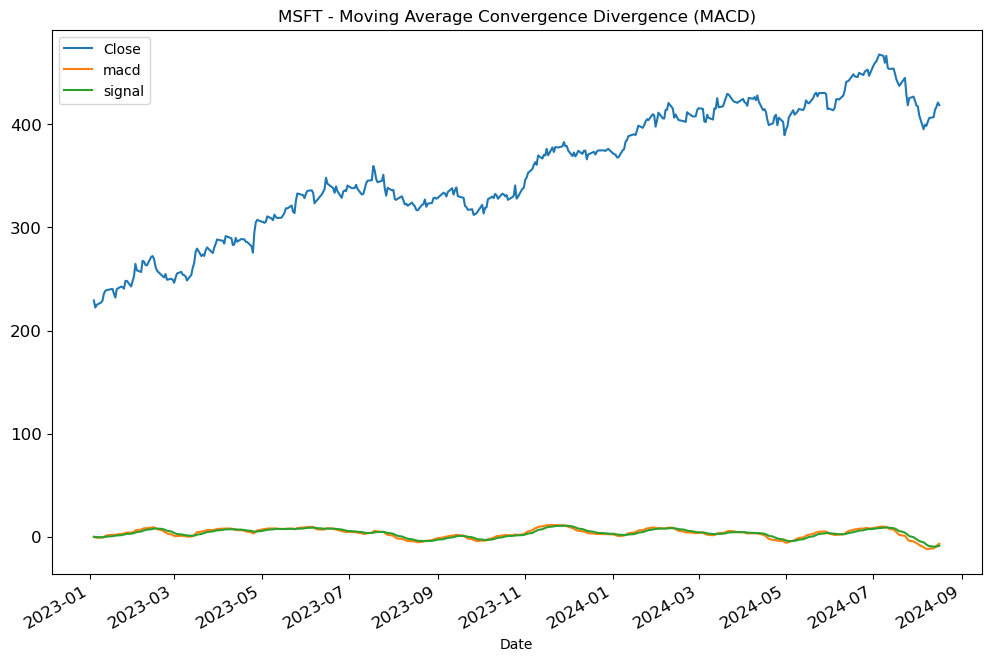

Total Return: 74.67%
Annualized Return: 41.24%
Annualized Volatility: 23.20%
Sharpe Ratio: 1.78


In [63]:
combined_analysis('MSFT', start_date='2023-01-01', end_date='2024-12-31')

[*********************100%***********************]  1 of 1 completed


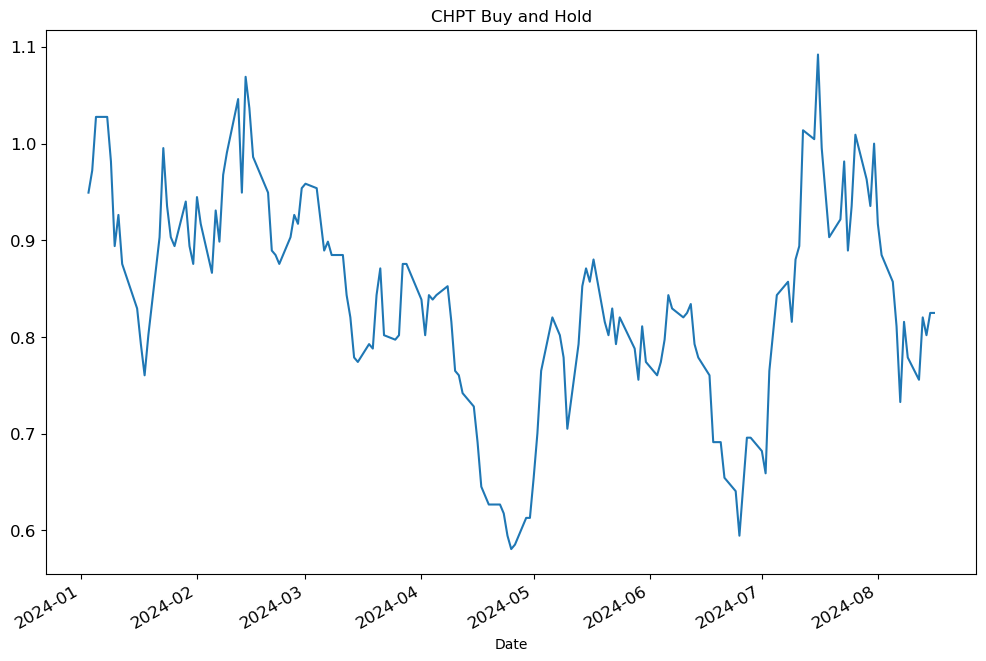

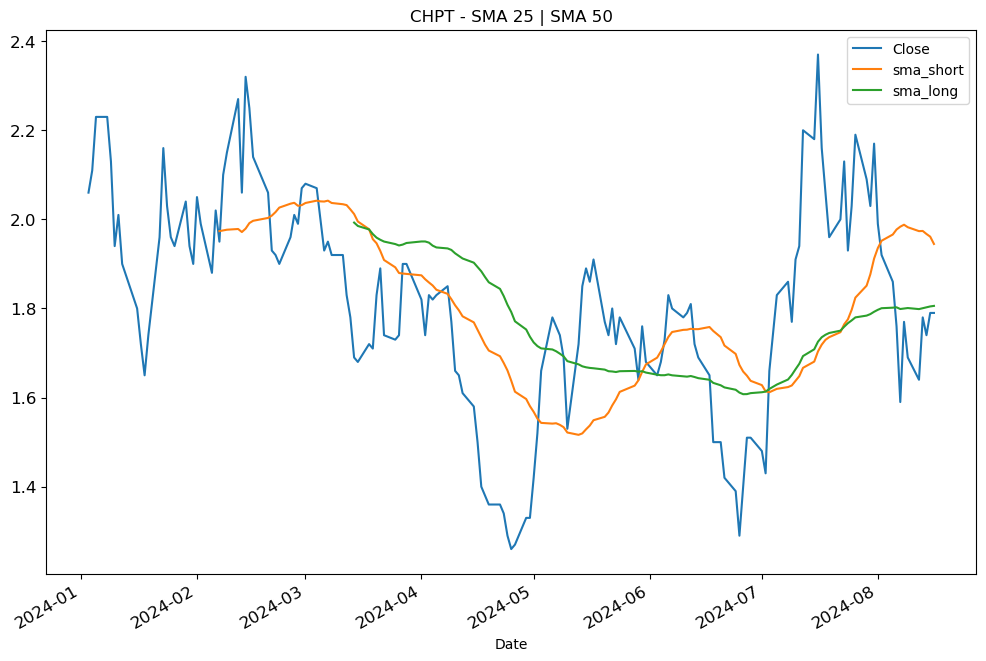

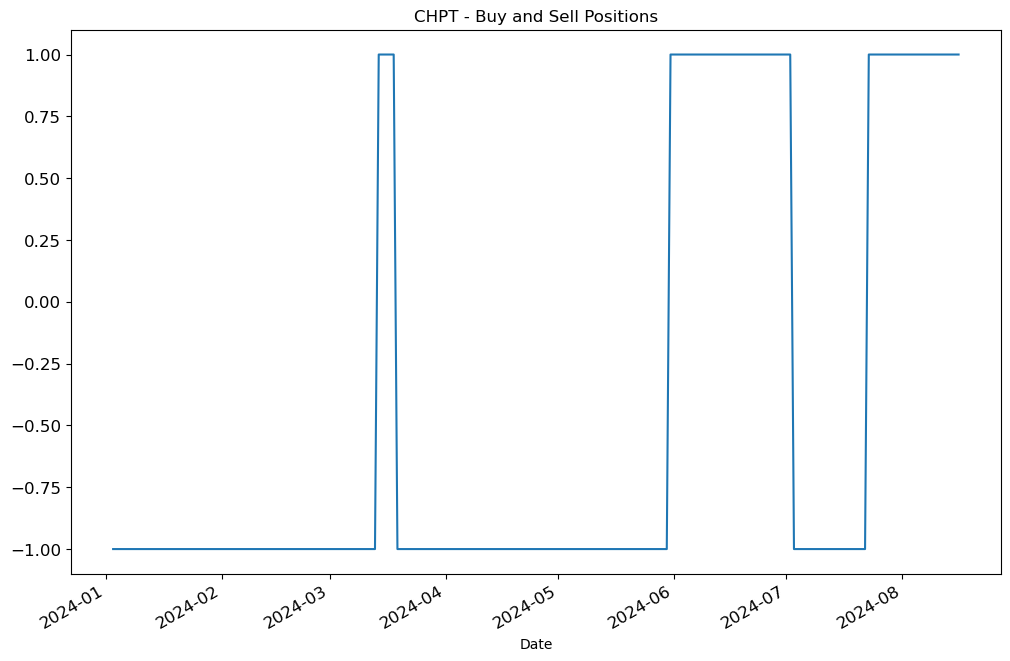

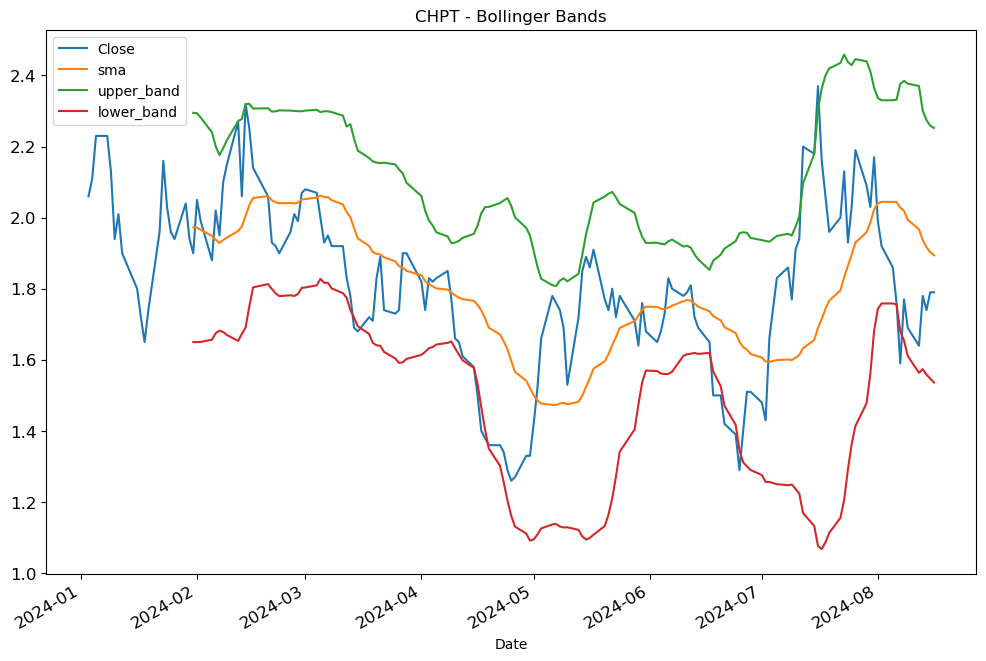

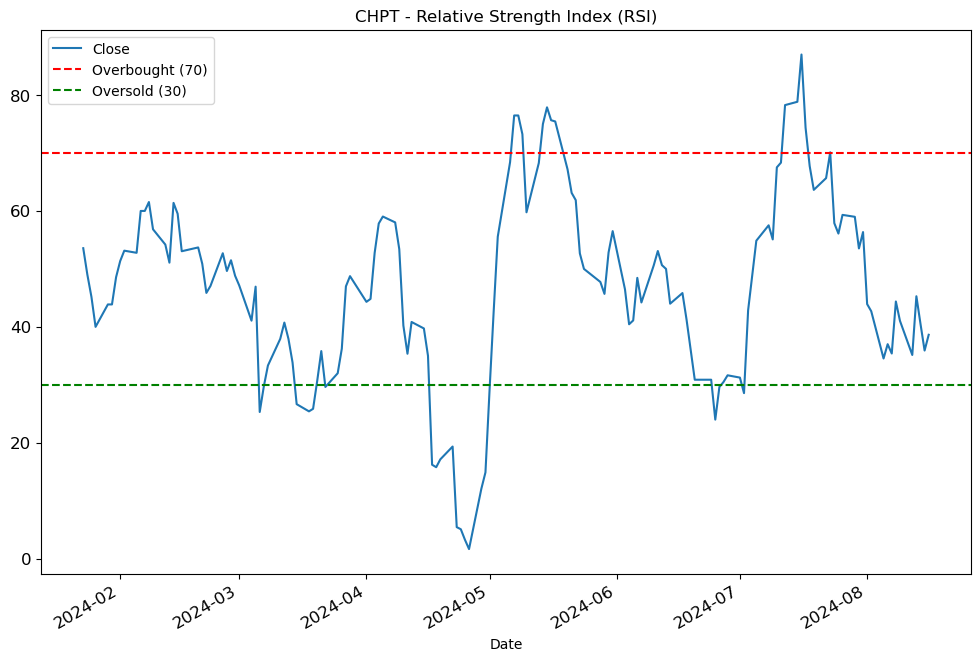

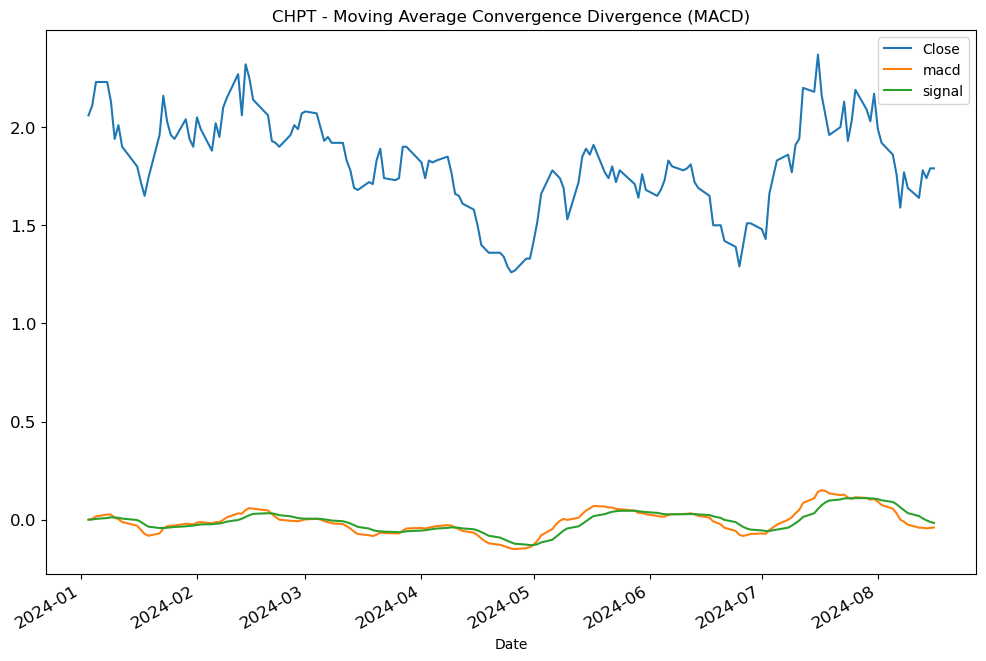

Total Return: -17.51%
Annualized Return: -26.58%
Annualized Volatility: 85.18%
Sharpe Ratio: -0.31


In [66]:
combined_analysis('CHPT', start_date='2024-01-01', end_date='2024-12-31')

[*********************100%***********************]  1 of 1 completed


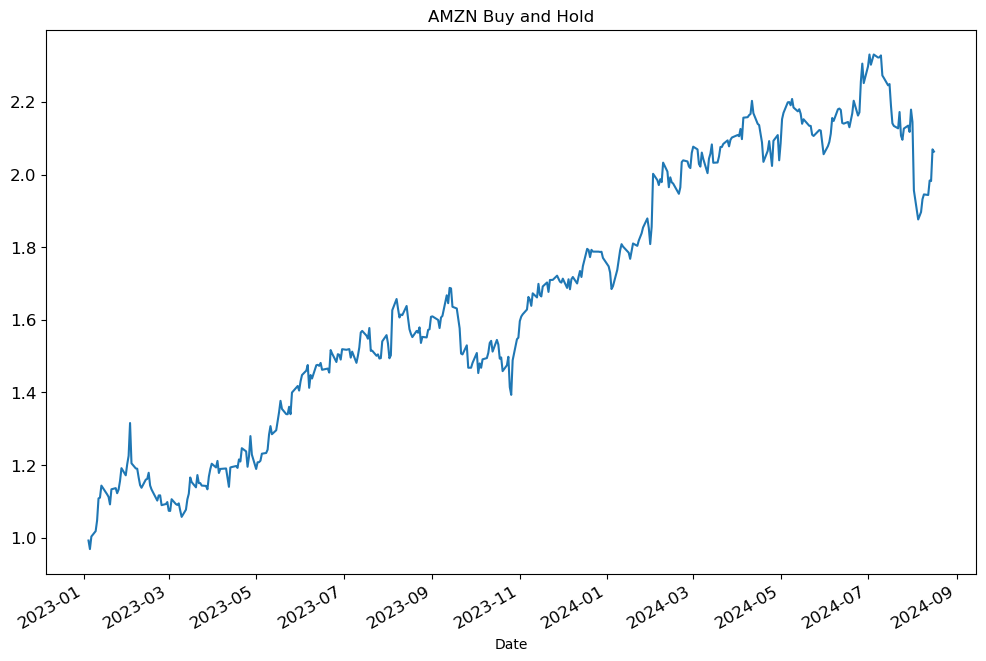

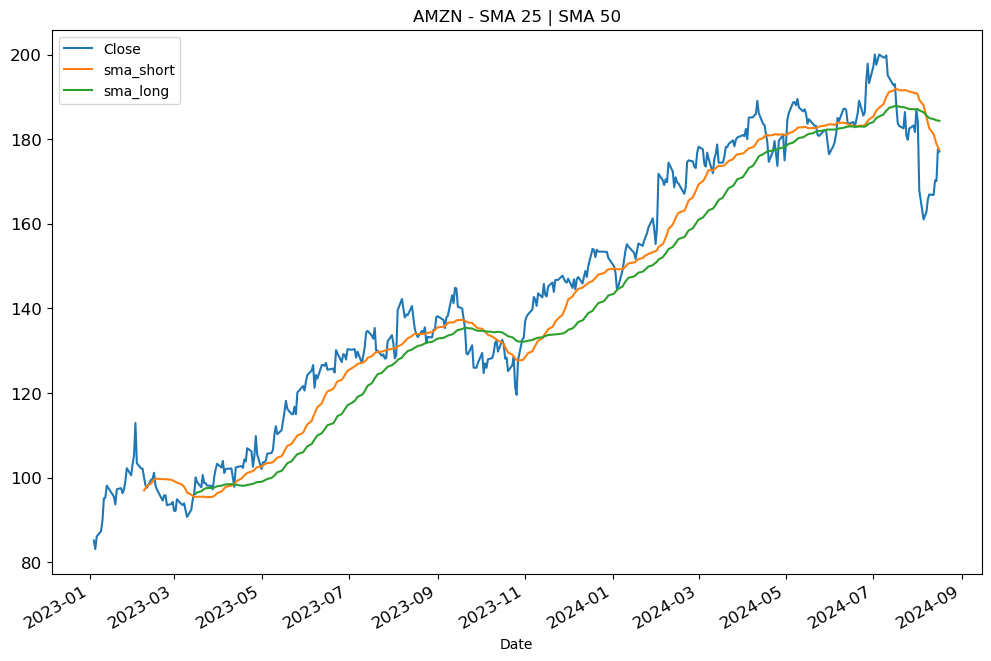

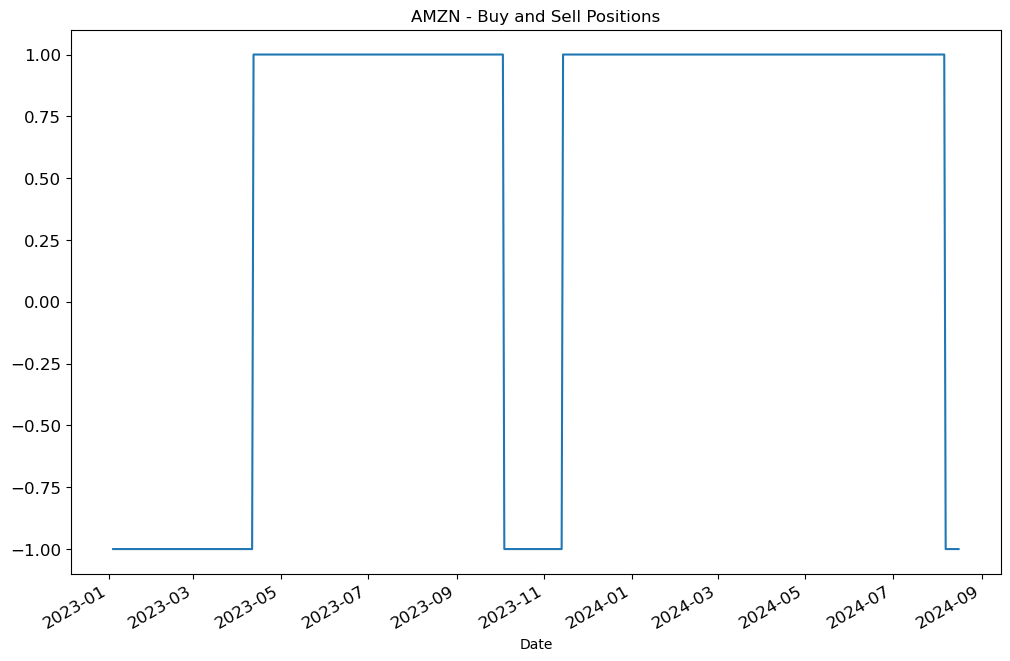

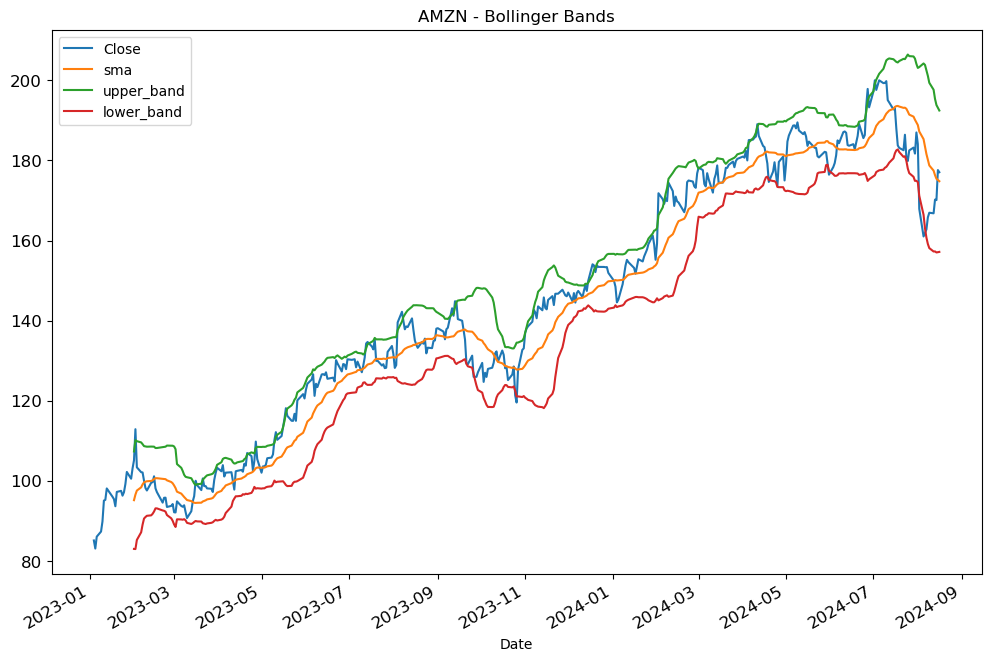

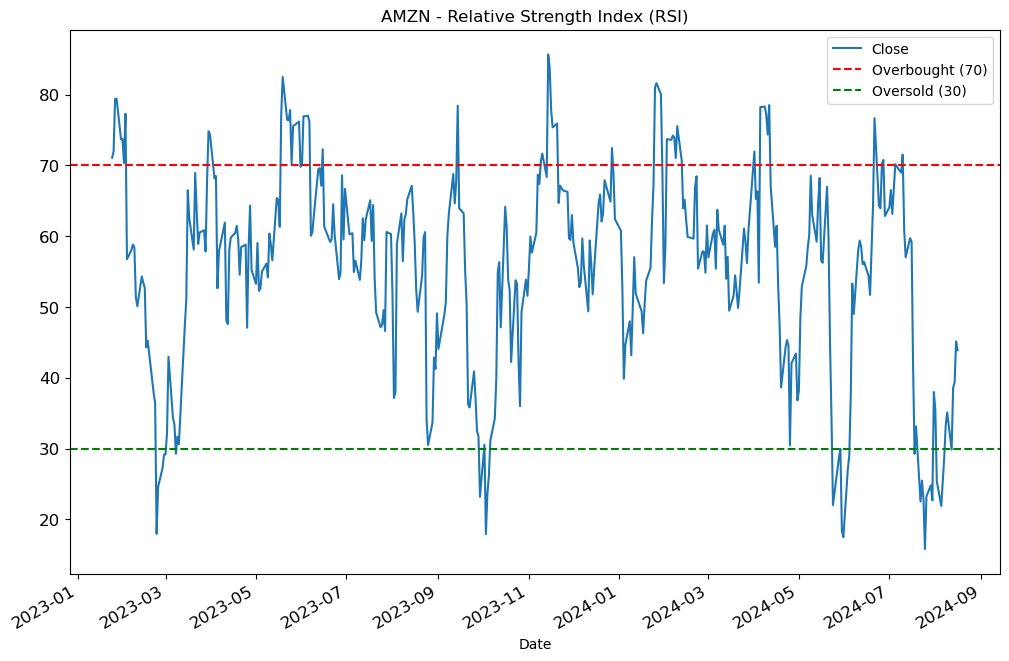

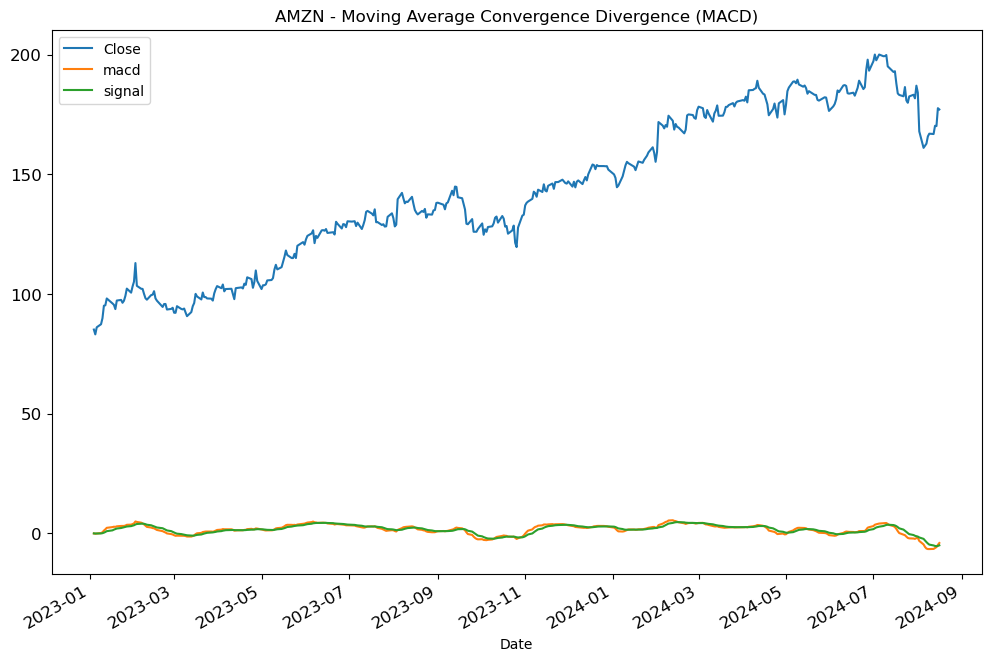

Total Return: 106.32%
Annualized Return: 56.58%
Annualized Volatility: 31.09%
Sharpe Ratio: 1.82


In [67]:
combined_analysis('AMZN', start_date='2023-01-01', end_date='2024-12-31')

[*********************100%***********************]  1 of 1 completed


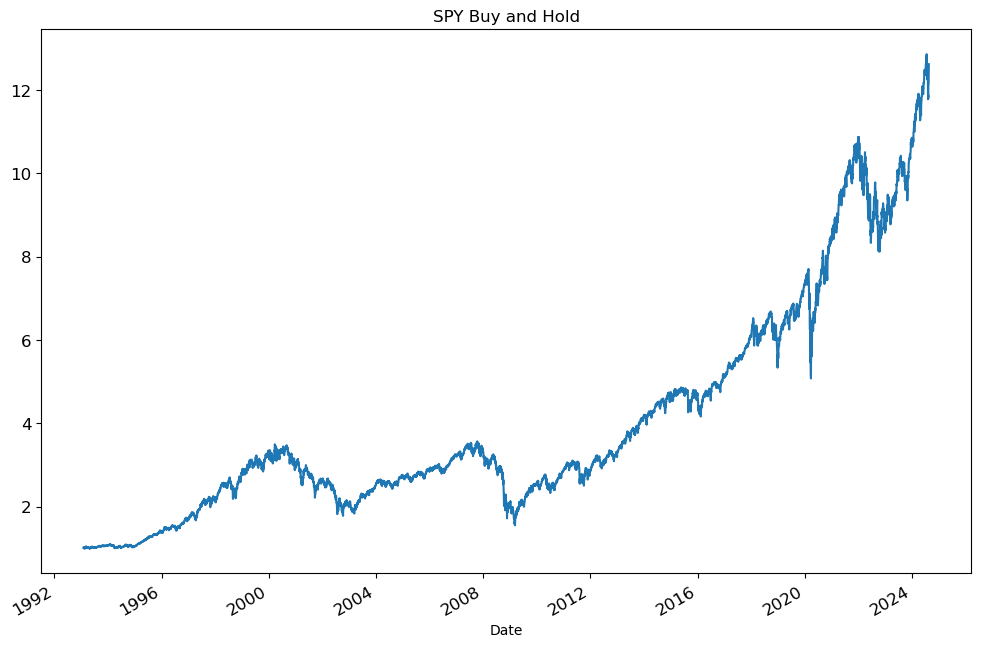

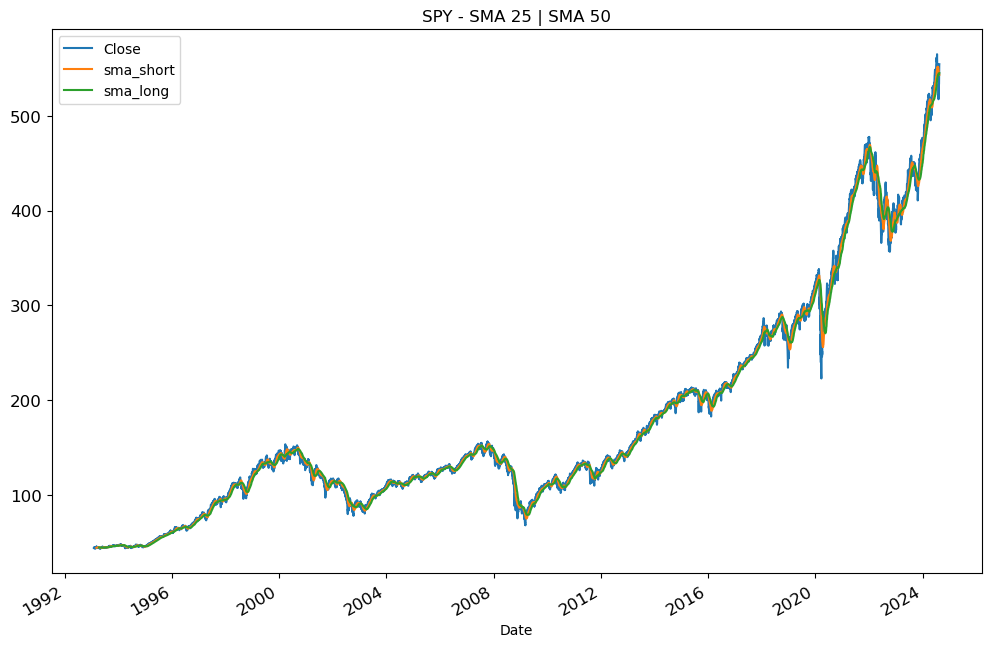

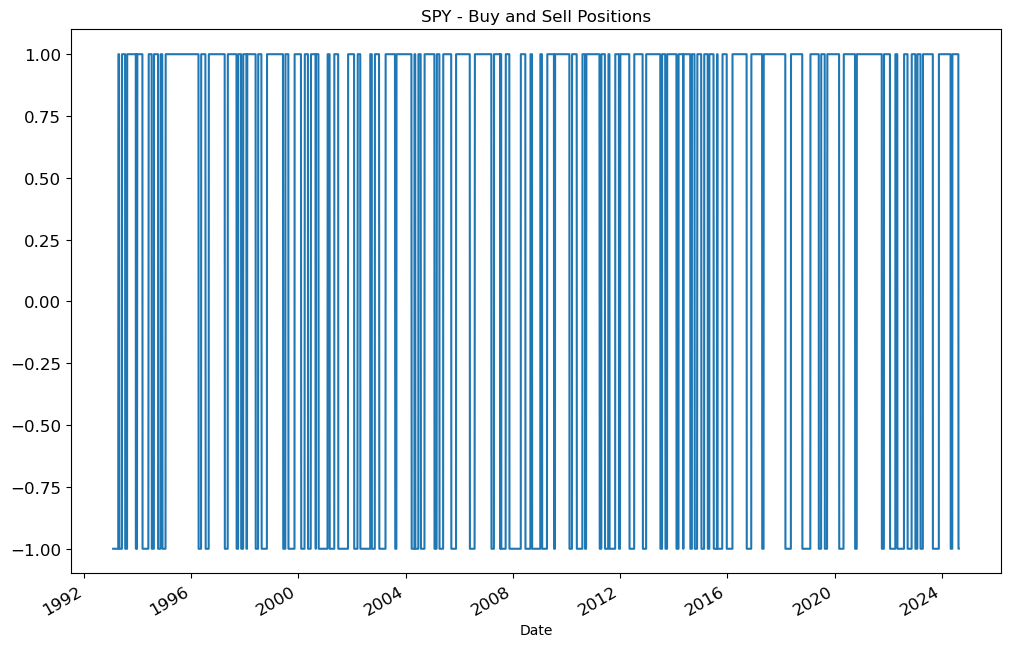

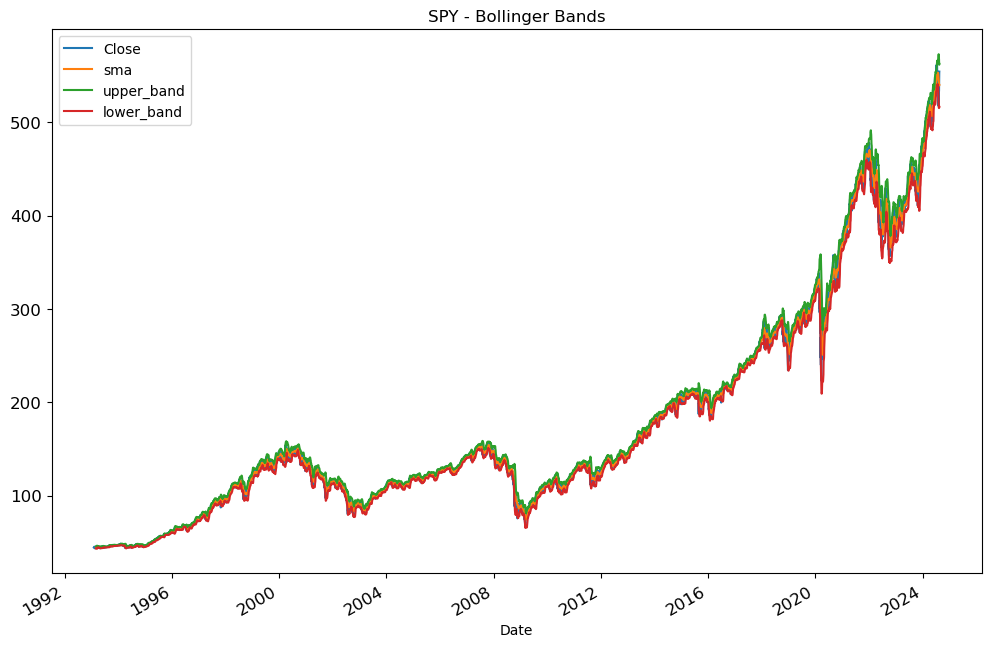

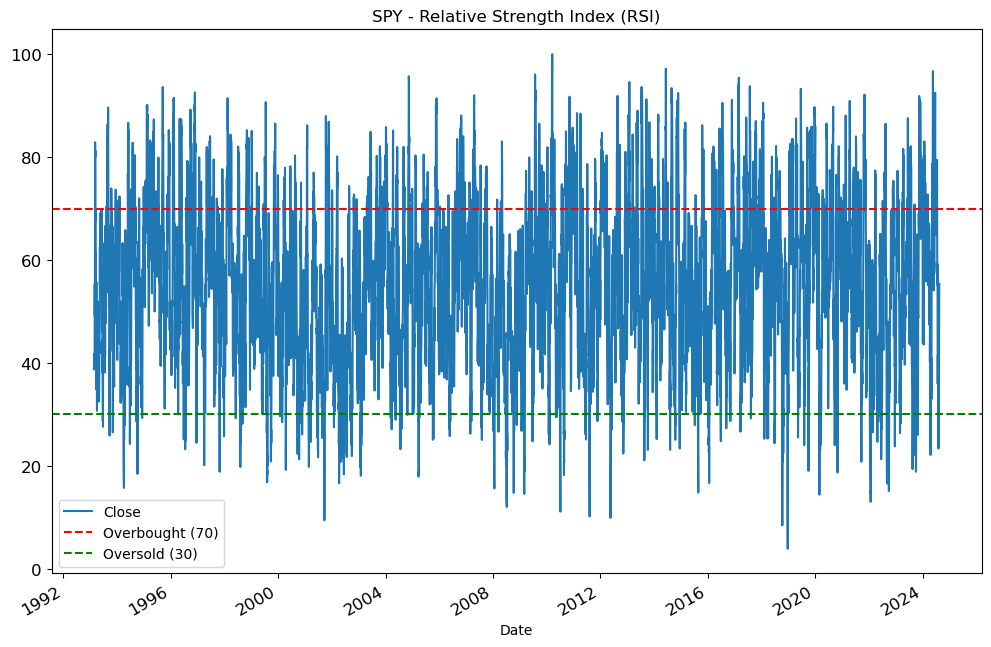

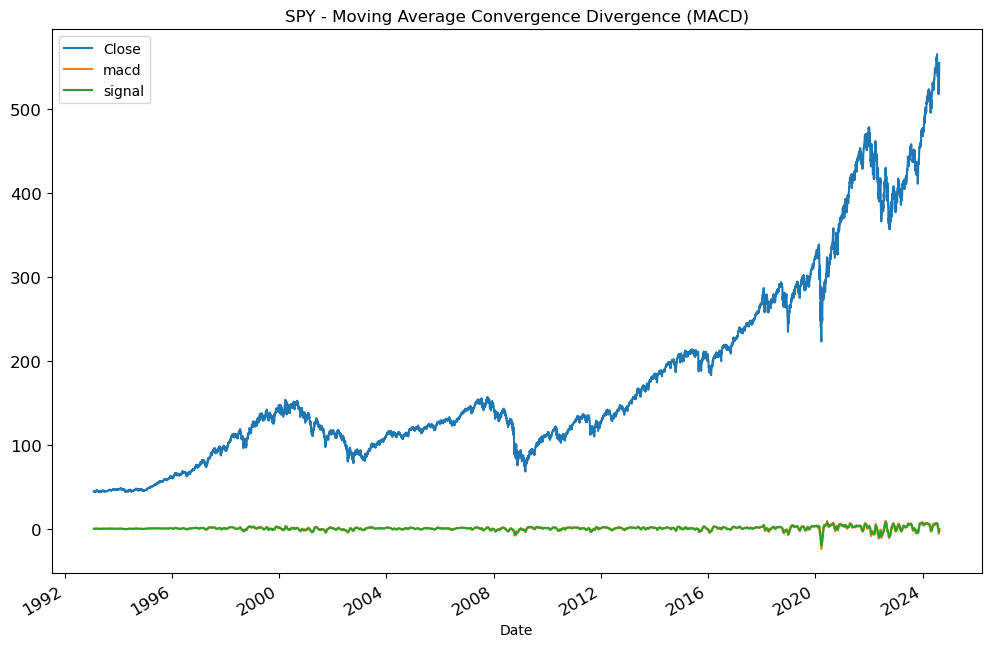

Total Return: 1161.59%
Annualized Return: 8.37%
Annualized Volatility: 18.72%
Sharpe Ratio: 0.45


In [69]:
combined_analysis('SPY', start_date='1990-01-01', end_date='2024-12-31')